In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/march-machine-learning-mania-2025/Conferences.csv
/kaggle/input/march-machine-learning-mania-2025/SeedBenchmarkStage1.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/WSecondaryTourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2025/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-20

In [2]:
!ls -GFlash ../input/march-machine-learning-mania-2025

total 175M
   0 drwxr-xr-x 2 nobody    0 Mar 17 03:22 ./
4.0K drwxr-xr-x 3 root   4.0K Mar 18 15:18 ../
 12K -rw-r--r-- 1 nobody 9.5K Mar 17 03:22 Cities.csv
4.0K -rw-r--r-- 1 nobody 1.7K Mar 17 03:22 Conferences.csv
176K -rw-r--r-- 1 nobody 175K Mar 17 03:22 MConferenceTourneyGames.csv
2.7M -rw-r--r-- 1 nobody 2.7M Mar 17 03:22 MGameCities.csv
117M -rw-r--r-- 1 nobody 117M Mar 17 03:22 MMasseyOrdinals.csv
 76K -rw-r--r-- 1 nobody  74K Mar 17 03:22 MNCAATourneyCompactResults.csv
136K -rw-r--r-- 1 nobody 135K Mar 17 03:22 MNCAATourneyDetailedResults.csv
 16K -rw-r--r-- 1 nobody  16K Mar 17 03:22 MNCAATourneySeedRoundSlots.csv
 40K -rw-r--r-- 1 nobody  39K Mar 17 03:22 MNCAATourneySeeds.csv
 52K -rw-r--r-- 1 nobody  51K Mar 17 03:22 MNCAATourneySlots.csv
5.4M -rw-r--r-- 1 nobody 5.4M Mar 17 03:22 MRegularSeasonCompactResults.csv
 12M -rw-r--r-- 1 nobody  12M Mar 17 03:22 MRegularSeasonDetailedResults.csv
4.0K -rw-r--r-- 1 nobody 1.8K Mar 17 03:22 MSeasons.csv
 64K -rw-r--r-- 1 nobody  61

In [3]:
import pandas as pd
import os
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [4]:
base_path = "../input/march-machine-learning-mania-2025/"  # Change this path as needed

In [5]:
# Load datasets
tourney_results = pd.read_csv(os.path.join(base_path, "MNCAATourneyDetailedResults.csv"))
tourney_seeds = pd.read_csv(os.path.join(base_path, "MNCAATourneySeeds.csv"))
tourney_slots = pd.read_csv(os.path.join(base_path, "MNCAATourneySlots.csv"))
tourney_seed_round_slots = pd.read_csv(os.path.join(base_path, "MNCAATourneySeedRoundSlots.csv"))
seasons = pd.read_csv(os.path.join(base_path, "MSeasons.csv"))

wtourney_results = pd.read_csv(os.path.join(base_path, "WNCAATourneyDetailedResults.csv"))
wtourney_seeds = pd.read_csv(os.path.join(base_path, "WNCAATourneySeeds.csv"))
wtourney_slots = pd.read_csv(os.path.join(base_path, "WNCAATourneySlots.csv"))
# wtourney_seed_round_slots = pd.read_csv(os.path.join(base_path, "WNCAATourneySeedRoundSlots.csv"))
wseasons = pd.read_csv(os.path.join(base_path, "WSeasons.csv"))

In [6]:
# Merge winner and loser seeds
tourney_results = tourney_results.merge(
    tourney_seeds, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how="left"
).rename(columns={'Seed': 'WSeed'}).drop(columns=['TeamID'])

tourney_results = tourney_results.merge(
    tourney_seeds, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how="left"
).rename(columns={'Seed': 'LSeed'}).drop(columns=['TeamID'])

In [7]:
#woman Merge winner and loser seeds
wtourney_results = wtourney_results.merge(
    wtourney_seeds, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how="left"
).rename(columns={'Seed': 'WSeed'}).drop(columns=['TeamID'])

wtourney_results = wtourney_results.merge(
    wtourney_seeds, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how="left"
).rename(columns={'Seed': 'LSeed'}).drop(columns=['TeamID'])

In [8]:
# Merge slots (outer join to prevent data loss)
tourney_results = tourney_results.merge(tourney_slots, on=["Season"], how="outer")
tourney_results = tourney_results.merge(tourney_seed_round_slots, left_on="WSeed", right_on="Seed", how="left").drop(columns=["Seed"])
tourney_results = tourney_results.merge(tourney_seed_round_slots, left_on="LSeed", right_on="Seed", how="left").drop(columns=["Seed"])

In [9]:
#woman Merge slots (outer join to prevent data loss)
wtourney_results = wtourney_results.merge(wtourney_slots, on=["Season"], how="outer")


In [10]:
print("Columns in tourney_results:", tourney_results.columns)

Columns in tourney_results: Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'WSeed', 'LSeed', 'Slot', 'StrongSeed', 'WeakSeed', 'GameRound_x',
       'GameSlot_x', 'EarlyDayNum_x', 'LateDayNum_x', 'GameRound_y',
       'GameSlot_y', 'EarlyDayNum_y', 'LateDayNum_y'],
      dtype='object')


In [11]:
#woman
print("Columns in tourney_results:", wtourney_results.columns)

Columns in tourney_results: Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'WSeed', 'LSeed', 'Slot', 'StrongSeed', 'WeakSeed'],
      dtype='object')


In [12]:
print(tourney_results["StrongSeed"].unique())

['W01' 'W02' 'W03' 'W04' 'W05' 'W06' 'W07' 'W08' 'X01' 'X02' 'X03' 'X04'
 'X05' 'X06' 'X07' 'X08' 'Y01' 'Y02' 'Y03' 'Y04' 'Y05' 'Y06' 'Y07' 'Y08'
 'Z01' 'Z02' 'Z03' 'Z04' 'Z05' 'Z06' 'Z07' 'Z08' 'R1W1' 'R1W2' 'R1W3'
 'R1W4' 'R1X1' 'R1X2' 'R1X3' 'R1X4' 'R1Y1' 'R1Y2' 'R1Y3' 'R1Y4' 'R1Z1'
 'R1Z2' 'R1Z3' 'R1Z4' 'R2W1' 'R2W2' 'R2X1' 'R2X2' 'R2Y1' 'R2Y2' 'R2Z1'
 'R2Z2' 'R3W1' 'R3X1' 'R3Y1' 'R3Z1' 'R4W1' 'R4Y1' 'R5WX' 'Y16a' 'W16a'
 'X16a' 'Z16a' 'W12a' 'Z11a' 'X12a' 'Z14a' 'Y11a' 'Z13a' 'Y12a' 'W11a'
 'X11a' 'Y10a' 'Z10a']


In [13]:
#woman
print(wtourney_results["StrongSeed"].unique())

['W01' 'W02' 'W03' 'W04' 'W05' 'W06' 'W07' 'W08' 'X01' 'X02' 'X03' 'X04'
 'X05' 'X06' 'X07' 'X08' 'Y01' 'Y02' 'Y03' 'Y04' 'Y05' 'Y06' 'Y07' 'Y08'
 'Z01' 'Z02' 'Z03' 'Z04' 'Z05' 'Z06' 'Z07' 'Z08' 'R1W1' 'R1W2' 'R1W3'
 'R1W4' 'R1X1' 'R1X2' 'R1X3' 'R1X4' 'R1Y1' 'R1Y2' 'R1Y3' 'R1Y4' 'R1Z1'
 'R1Z2' 'R1Z3' 'R1Z4' 'R2W1' 'R2W2' 'R2X1' 'R2X2' 'R2Y1' 'R2Y2' 'R2Z1'
 'R2Z2' 'R3W1' 'R3X1' 'R3Y1' 'R3Z1' 'R4W1' 'R4Y1' 'R5WX' 'W16a' 'X11a'
 'Y11a' 'Y16a' 'W11a' 'X16a' 'Z11a' 'Z12a']


In [14]:
print(tourney_results["WLoc"].unique())

[nan 'N']


In [15]:

print(wtourney_results["WLoc"].unique())

[nan 'N' 'H' 'A']


In [16]:
tourney_results_cleaned = tourney_results.merge(seasons, on="Season", how="left")

In [17]:
wtourney_results_cleaned = wtourney_results.merge(seasons, on="Season", how="left")

In [18]:
# Drop unnecessary columns
drop_columns = ["DayZero", "RegionW", "RegionX", "RegionY", "RegionZ"]
tourney_results_cleaned.drop(columns=drop_columns, inplace=True, errors="ignore")

In [19]:
# woman Drop unnecessary columns
wdrop_columns = ["DayZero", "RegionW", "RegionX", "RegionY", "RegionZ"]
wtourney_results_cleaned.drop(columns=drop_columns, inplace=True, errors="ignore")

In [20]:
print("Columns in tourney_results:", tourney_results.columns)

Columns in tourney_results: Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'WSeed', 'LSeed', 'Slot', 'StrongSeed', 'WeakSeed', 'GameRound_x',
       'GameSlot_x', 'EarlyDayNum_x', 'LateDayNum_x', 'GameRound_y',
       'GameSlot_y', 'EarlyDayNum_y', 'LateDayNum_y'],
      dtype='object')


In [21]:
#woman
print("Columns in wtourney_results:", wtourney_results.columns)

Columns in wtourney_results: Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'WSeed', 'LSeed', 'Slot', 'StrongSeed', 'WeakSeed'],
      dtype='object')


In [22]:
# Extract Region and Seed Number
tourney_results_cleaned["WRegion"] = tourney_results_cleaned["WSeed"].str[0]
tourney_results_cleaned["LRegion"] = tourney_results_cleaned["LSeed"].str[0]

In [23]:
# Extract Region and Seed Number
wtourney_results_cleaned["WRegion"] = tourney_results_cleaned["WSeed"].str[0]
wtourney_results_cleaned["LRegion"] = tourney_results_cleaned["LSeed"].str[0]

In [24]:
print(tourney_results_cleaned["WRegion"].unique())

[nan 'X' 'Z' 'W' 'Y']


In [25]:
print(tourney_results_cleaned["LRegion"].unique())

[nan 'X' 'Z' 'W' 'Y']


In [26]:
print(wtourney_results_cleaned["WRegion"].unique())
print(wtourney_results_cleaned["LRegion"].unique())

[nan 'X' 'Z' 'W' 'Y']
[nan 'X' 'Z' 'W' 'Y']


In [27]:
# Extract play-in flag before removing a/b
tourney_results_cleaned["WPlayIn"] = tourney_results_cleaned["WSeed"].str[-1].isin(["a", "b"]).astype(int)
tourney_results_cleaned["LPlayIn"] = tourney_results_cleaned["LSeed"].str[-1].isin(["a", "b"]).astype(int)

In [28]:
# Woman Extract play-in flag before removing a/b
wtourney_results_cleaned["WPlayIn"] = wtourney_results_cleaned["WSeed"].str[-1].isin(["a", "b"]).astype(int)
wtourney_results_cleaned["LPlayIn"] = wtourney_results_cleaned["LSeed"].str[-1].isin(["a", "b"]).astype(int)

In [29]:
print(tourney_results_cleaned["WPlayIn"].unique())

[0 1]


In [30]:
print(wtourney_results_cleaned["WPlayIn"].unique())

[0 1]


In [31]:
# Remove 'a'/'b' before converting to integer
tourney_results_cleaned["WSeedNum"] = tourney_results_cleaned["WSeed"].str[1:3].str.replace(r"[ab]", "", regex=True).astype(float)
tourney_results_cleaned["LSeedNum"] = tourney_results_cleaned["LSeed"].str[1:3].str.replace(r"[ab]", "", regex=True).astype(float)

In [32]:
# Remove 'a'/'b' before converting to integer
wtourney_results_cleaned["WSeedNum"] = wtourney_results_cleaned["WSeed"].str[1:3].str.replace(r"[ab]", "", regex=True).astype(float)
wtourney_results_cleaned["LSeedNum"] = wtourney_results_cleaned["LSeed"].str[1:3].str.replace(r"[ab]", "", regex=True).astype(float)

In [33]:
print(tourney_results_cleaned["WSeedNum"].unique())

[nan 16.  1. 10. 11.  8.  5.  3.  9.  4.  2.  6. 13. 12.  7. 14. 15.]


In [34]:
print(wtourney_results_cleaned["WSeedNum"].unique())

[nan  4.  8.  2.  3.  5.  7.  6.  1. 11. 10. 12.  9. 13. 16.]


In [35]:
# Drop old seed columns if no longer needed
tourney_results_cleaned.drop(columns=["WSeed", "LSeed"], inplace=True)

In [36]:
# Drop old seed columns if no longer needed
wtourney_results_cleaned.drop(columns=["WSeed", "LSeed"], inplace=True)

In [37]:
columns_to_drop = ['StrongSeed', 'WeakSeed', 'GameRound_x', 'GameSlot_x', 'EarlyDayNum_x', 'LateDayNum_x',
                   'GameRound_y', 'GameSlot_y', 'EarlyDayNum_y', 'LateDayNum_y']
tourney_results_cleaned.drop(columns=columns_to_drop, inplace=True, errors="ignore")

In [38]:
wcolumns_to_drop = ['StrongSeed', 'WeakSeed', 'GameRound_x', 'GameSlot_x', 'EarlyDayNum_x', 'LateDayNum_x',
                   'GameRound_y', 'GameSlot_y', 'EarlyDayNum_y', 'LateDayNum_y']
wtourney_results_cleaned.drop(columns=columns_to_drop, inplace=True, errors="ignore")

In [39]:
# Display cleaned columns
print("Updated Columns:", tourney_results_cleaned.columns)

Updated Columns: Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'Slot', 'WRegion', 'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum',
       'LSeedNum'],
      dtype='object')


In [40]:
# Display cleaned columns
print("Updated Columns:", wtourney_results_cleaned.columns)

Updated Columns: Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'Slot', 'WRegion', 'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum',
       'LSeedNum'],
      dtype='object')


In [41]:
print(tourney_results_cleaned.head())

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    1985     NaN      NaN     NaN      NaN     NaN  NaN    NaN   NaN   NaN   
1    1985     NaN      NaN     NaN      NaN     NaN  NaN    NaN   NaN   NaN   
2    1985     NaN      NaN     NaN      NaN     NaN  NaN    NaN   NaN   NaN   
3    1985     NaN      NaN     NaN      NaN     NaN  NaN    NaN   NaN   NaN   
4    1985     NaN      NaN     NaN      NaN     NaN  NaN    NaN   NaN   NaN   

   ...  LStl  LBlk  LPF  Slot  WRegion  LRegion  WPlayIn  LPlayIn  WSeedNum  \
0  ...   NaN   NaN  NaN  R1W1      NaN      NaN        0        0       NaN   
1  ...   NaN   NaN  NaN  R1W2      NaN      NaN        0        0       NaN   
2  ...   NaN   NaN  NaN  R1W3      NaN      NaN        0        0       NaN   
3  ...   NaN   NaN  NaN  R1W4      NaN      NaN        0        0       NaN   
4  ...   NaN   NaN  NaN  R1W5      NaN      NaN        0        0       NaN   

   LSeedNum  
0       NaN  
1       NaN  
2       

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [42]:
print(wtourney_results_cleaned.head())

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    1998     NaN      NaN     NaN      NaN     NaN  NaN    NaN   NaN   NaN   
1    1998     NaN      NaN     NaN      NaN     NaN  NaN    NaN   NaN   NaN   
2    1998     NaN      NaN     NaN      NaN     NaN  NaN    NaN   NaN   NaN   
3    1998     NaN      NaN     NaN      NaN     NaN  NaN    NaN   NaN   NaN   
4    1998     NaN      NaN     NaN      NaN     NaN  NaN    NaN   NaN   NaN   

   ...  LStl  LBlk  LPF  Slot  WRegion  LRegion  WPlayIn  LPlayIn  WSeedNum  \
0  ...   NaN   NaN  NaN  R1W1      NaN      NaN        0        0       NaN   
1  ...   NaN   NaN  NaN  R1W2      NaN      NaN        0        0       NaN   
2  ...   NaN   NaN  NaN  R1W3      NaN      NaN        0        0       NaN   
3  ...   NaN   NaN  NaN  R1W4      NaN      NaN        0        0       NaN   
4  ...   NaN   NaN  NaN  R1W5      NaN      NaN        0        0       NaN   

   LSeedNum  
0       NaN  
1       NaN  
2       

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [43]:
# Load Compact Results
tourney_compact = pd.read_csv(os.path.join(base_path, "MNCAATourneyCompactResults.csv"))

In [44]:
# Load Compact Results
wtourney_compact = pd.read_csv(os.path.join(base_path, "WNCAATourneyCompactResults.csv"))

In [45]:
# Merge with existing results (fill in missing older data)
tourney_results = pd.concat([tourney_compact, tourney_results_cleaned], ignore_index=True)

In [46]:
# Woman Merge with existing results (fill in missing older data)
wtourney_results = pd.concat([wtourney_compact, wtourney_results_cleaned], ignore_index=True)

In [47]:
# Display updated dataset
print(tourney_results.head())  # Check first few rows
print(tourney_results['Season'].min(), "to", tourney_results['Season'].max())  # Check season range

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    1985   136.0   1116.0    63.0   1234.0    54.0    N    0.0   NaN   NaN   
1    1985   136.0   1120.0    59.0   1345.0    58.0    N    0.0   NaN   NaN   
2    1985   136.0   1207.0    68.0   1250.0    43.0    N    0.0   NaN   NaN   
3    1985   136.0   1229.0    58.0   1425.0    55.0    N    0.0   NaN   NaN   
4    1985   136.0   1242.0    49.0   1325.0    38.0    N    0.0   NaN   NaN   

   ...  LStl  LBlk  LPF  Slot  WRegion  LRegion  WPlayIn  LPlayIn  WSeedNum  \
0  ...   NaN   NaN  NaN   NaN      NaN      NaN      NaN      NaN       NaN   
1  ...   NaN   NaN  NaN   NaN      NaN      NaN      NaN      NaN       NaN   
2  ...   NaN   NaN  NaN   NaN      NaN      NaN      NaN      NaN       NaN   
3  ...   NaN   NaN  NaN   NaN      NaN      NaN      NaN      NaN       NaN   
4  ...   NaN   NaN  NaN   NaN      NaN      NaN      NaN      NaN       NaN   

   LSeedNum  
0       NaN  
1       NaN  
2       

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [48]:
# Display updated dataset
print(wtourney_results.head())  # Check first few rows
print(wtourney_results['Season'].min(), "to", wtourney_results['Season'].max())  # Check season range

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    1998   137.0   3104.0    94.0   3422.0    46.0    H    0.0   NaN   NaN   
1    1998   137.0   3112.0    75.0   3365.0    63.0    H    0.0   NaN   NaN   
2    1998   137.0   3163.0    93.0   3193.0    52.0    H    0.0   NaN   NaN   
3    1998   137.0   3198.0    59.0   3266.0    45.0    H    0.0   NaN   NaN   
4    1998   137.0   3203.0    74.0   3208.0    72.0    A    0.0   NaN   NaN   

   ...  LStl  LBlk  LPF  Slot  WRegion  LRegion  WPlayIn  LPlayIn  WSeedNum  \
0  ...   NaN   NaN  NaN   NaN      NaN      NaN      NaN      NaN       NaN   
1  ...   NaN   NaN  NaN   NaN      NaN      NaN      NaN      NaN       NaN   
2  ...   NaN   NaN  NaN   NaN      NaN      NaN      NaN      NaN       NaN   
3  ...   NaN   NaN  NaN   NaN      NaN      NaN      NaN      NaN       NaN   
4  ...   NaN   NaN  NaN   NaN      NaN      NaN      NaN      NaN       NaN   

   LSeedNum  
0       NaN  
1       NaN  
2       

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [49]:
# List of numeric columns to fill
numeric_columns = ["WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR",
                   "WAst", "WTO", "WStl", "WBlk", "WPF", "LFGM", "LFGA", "LFGM3",
                   "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF"]

In [50]:
#Woman List of numeric columns to fill
wnumeric_columns = ["WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR",
                   "WAst", "WTO", "WStl", "WBlk", "WPF", "LFGM", "LFGA", "LFGM3",
                   "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF"]

In [51]:
# Compute average values using only 2003+ data
avg_stats = tourney_results[tourney_results["Season"] >= 2003][numeric_columns].mean()

In [52]:
#Woman Compute average values using only 2003+ data
wavg_stats = wtourney_results[wtourney_results["Season"] >= 2003][wnumeric_columns].mean()

In [53]:
# Fill missing values with computed averages
tourney_results[numeric_columns] = tourney_results[numeric_columns].fillna(avg_stats)

In [54]:
# Fill missing values with computed averages
wtourney_results[wnumeric_columns] = wtourney_results[wnumeric_columns].fillna(wavg_stats)

In [55]:
# Fill categorical columns with the most common value
categorical_columns = ["WLoc", "WRegion", "LRegion"]
for col in categorical_columns:
    mode_value = tourney_results[col].mode()[0]  # Get the most common value
    tourney_results[col] = tourney_results[col].fillna(mode_value)

In [56]:
# Fill categorical columns with the most common value
wcategorical_columns = ["WLoc", "WRegion", "LRegion"]
for col in wcategorical_columns:
    wmode_value = wtourney_results[col].mode()[0]  # Get the most common value
    wtourney_results[col] = wtourney_results[col].fillna(wmode_value)

In [57]:
#Fill Missing Slot, WPlayIn, and LPlayIn with 0
tourney_results["Slot"] = tourney_results["Slot"].fillna("Unknown")
tourney_results["WPlayIn"] = tourney_results["WPlayIn"].fillna(0).astype(int)
tourney_results["LPlayIn"] = tourney_results["LPlayIn"].fillna(0).astype(int)

In [58]:
#Woman Fill Missing Slot, WPlayIn, and LPlayIn with 0
wtourney_results["Slot"] = wtourney_results["Slot"].fillna("Unknown")
wtourney_results["WPlayIn"] = wtourney_results["WPlayIn"].fillna(0).astype(int)
wtourney_results["LPlayIn"] = wtourney_results["LPlayIn"].fillna(0).astype(int)

In [59]:
# Check if there are still missing values
missing_values_after = tourney_results.isnull().sum()
print(missing_values_after[missing_values_after > 0])  # Should return empty if all missing values are handled

DayNum      1203
WTeamID     1203
WScore      1203
LTeamID     1203
LScore      1203
NumOT       1203
WSeedNum    3721
LSeedNum    3721
dtype: int64


In [60]:
# Woman Check if there are still missing values
wmissing_values_after = wtourney_results.isnull().sum()
print(wmissing_values_after[wmissing_values_after > 0])  # Should return empty if all missing values are handled

DayNum       886
WTeamID      886
WScore       886
LTeamID      886
LScore       886
NumOT        886
WSeedNum    2536
LSeedNum    2536
dtype: int64


In [61]:
# Fill missing values using tournament compact results (only if available)
for col in ["DayNum", "WTeamID", "LTeamID", "WScore", "LScore", "NumOT"]:
    tourney_results[col] = tourney_results[col].fillna(method="ffill")  # Forward fill

<ipython-input-61-6837b32ab088>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tourney_results[col] = tourney_results[col].fillna(method="ffill")  # Forward fill


In [62]:
# Fill missing values using tournament compact results (only if available)
for col in ["DayNum", "WTeamID", "LTeamID", "WScore", "LScore", "NumOT"]:
    wtourney_results[col] = wtourney_results[col].fillna(method="ffill")  # Forward fill

<ipython-input-62-fe638c949c09>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wtourney_results[col] = wtourney_results[col].fillna(method="ffill")  # Forward fill


In [63]:
# Fill missing seeds with the most common value per team
tourney_results["WSeedNum"] = tourney_results.groupby("WTeamID")["WSeedNum"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 16))
tourney_results["LSeedNum"] = tourney_results.groupby("LTeamID")["LSeedNum"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 16))

In [64]:
# Fill missing seeds with the most common value per team
wtourney_results["WSeedNum"] = wtourney_results.groupby("WTeamID")["WSeedNum"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 16))
wtourney_results["LSeedNum"] = wtourney_results.groupby("LTeamID")["LSeedNum"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 16))

In [65]:
missing_values_after = tourney_results.isnull().sum()
print(missing_values_after[missing_values_after > 0])

Series([], dtype: int64)


In [66]:
wmissing_values_after = wtourney_results.isnull().sum()
print(wmissing_values_after[wmissing_values_after > 0])

Series([], dtype: int64)


In [67]:
print(tourney_results.head())

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT       WFGM  \
0    1985   136.0   1116.0    63.0   1234.0    54.0    N    0.0  26.485341   
1    1985   136.0   1120.0    59.0   1345.0    58.0    N    0.0  26.485341   
2    1985   136.0   1207.0    68.0   1250.0    43.0    N    0.0  26.485341   
3    1985   136.0   1229.0    58.0   1425.0    55.0    N    0.0  26.485341   
4    1985   136.0   1242.0    49.0   1325.0    38.0    N    0.0  26.485341   

        WFGA  ...      LStl      LBlk       LPF     Slot  WRegion  LRegion  \
0  55.827448  ...  5.671245  2.946253  18.59166  Unknown        Y        W   
1  55.827448  ...  5.671245  2.946253  18.59166  Unknown        Y        W   
2  55.827448  ...  5.671245  2.946253  18.59166  Unknown        Y        W   
3  55.827448  ...  5.671245  2.946253  18.59166  Unknown        Y        W   
4  55.827448  ...  5.671245  2.946253  18.59166  Unknown        Y        W   

   WPlayIn  LPlayIn  WSeedNum  LSeedNum  
0        0        0 

In [68]:
print(wtourney_results.head())

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT       WFGM  \
0    1998   137.0   3104.0    94.0   3422.0    46.0    H    0.0  27.838585   
1    1998   137.0   3112.0    75.0   3365.0    63.0    H    0.0  27.838585   
2    1998   137.0   3163.0    93.0   3193.0    52.0    H    0.0  27.838585   
3    1998   137.0   3198.0    59.0   3266.0    45.0    H    0.0  27.838585   
4    1998   137.0   3203.0    74.0   3208.0    72.0    A    0.0  27.838585   

        WFGA  ...      LStl      LBlk        LPF     Slot  WRegion  LRegion  \
0  60.098432  ...  6.642177  3.020849  17.833508  Unknown        Z        Z   
1  60.098432  ...  6.642177  3.020849  17.833508  Unknown        Z        Z   
2  60.098432  ...  6.642177  3.020849  17.833508  Unknown        Z        Z   
3  60.098432  ...  6.642177  3.020849  17.833508  Unknown        Z        Z   
4  60.098432  ...  6.642177  3.020849  17.833508  Unknown        Z        Z   

   WPlayIn  LPlayIn  WSeedNum  LSeedNum  
0        0    

In [69]:
# Load the team conference data
team_conferences = pd.read_csv(os.path.join(base_path, "MTeamConferences.csv"))

In [70]:
# Load the team conference data
wteam_conferences = pd.read_csv(os.path.join(base_path, "WTeamConferences.csv"))

In [71]:
# Merge Winner Team's Conference (WConf)
tourney_results = tourney_results.merge(
    team_conferences,
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID'],
    how="left"
).rename(columns={'ConfAbbrev': 'WConf'}).drop(columns=['TeamID'])

In [72]:
#Woman Merge Winner Team's Conference (WConf)
wtourney_results = wtourney_results.merge(
    wteam_conferences,
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID'],
    how="left"
).rename(columns={'ConfAbbrev': 'WConf'}).drop(columns=['TeamID'])

In [73]:
# Merge Loser Team's Conference (LConf)
tourney_results = tourney_results.merge(
    team_conferences,
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID'],
    how="left"
).rename(columns={'ConfAbbrev': 'LConf'}).drop(columns=['TeamID'])

In [74]:
#Woman Merge Loser Team's Conference (LConf)
wtourney_results = wtourney_results.merge(
    wteam_conferences,
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID'],
    how="left"
).rename(columns={'ConfAbbrev': 'LConf'}).drop(columns=['TeamID'])

In [75]:
# Load the conference tournament games data
conference_tourney_games = pd.read_csv(os.path.join(base_path,"MConferenceTourneyGames.csv"))

In [76]:
# Woman Load the conference tournament games data
wconference_tourney_games = pd.read_csv(os.path.join(base_path,"WConferenceTourneyGames.csv"))

In [77]:
# Rename columns to avoid confusion
conference_tourney_games = conference_tourney_games.rename(columns={
    "WTeamID": "Conf_WTeamID",
    "LTeamID": "Conf_LTeamID"
})

In [78]:
#Woman Rename columns to avoid confusion
wconference_tourney_games = wconference_tourney_games.rename(columns={
    "WTeamID": "Conf_WTeamID",
    "LTeamID": "Conf_LTeamID"
})

In [79]:
# Merge to check if the game was a conference tournament game
tourney_results = tourney_results.merge(
    conference_tourney_games[['Season', 'ConfAbbrev', 'DayNum', 'Conf_WTeamID', 'Conf_LTeamID']],
    left_on=['Season', 'WTeamID', 'LTeamID'],
    right_on=['Season', 'Conf_WTeamID', 'Conf_LTeamID'],
    how="left"
).rename(columns={'ConfAbbrev': 'ConfTourney'})

In [80]:
# Woman Merge to check if the game was a conference tournament game
wtourney_results = wtourney_results.merge(
    wconference_tourney_games[['Season', 'ConfAbbrev', 'DayNum', 'Conf_WTeamID', 'Conf_LTeamID']],
    left_on=['Season', 'WTeamID', 'LTeamID'],
    right_on=['Season', 'Conf_WTeamID', 'Conf_LTeamID'],
    how="left"
).rename(columns={'ConfAbbrev': 'ConfTourney'})

In [81]:
print(tourney_results.columns)

Index(['Season', 'DayNum_x', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'Slot', 'WRegion', 'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum',
       'LSeedNum', 'WConf', 'LConf', 'ConfTourney', 'DayNum_y', 'Conf_WTeamID',
       'Conf_LTeamID'],
      dtype='object')


In [82]:
print(tourney_results[['Season', 'WTeamID', 'WConf', 'LTeamID', 'LConf', 'ConfTourney']].head())

   Season  WTeamID      WConf  LTeamID    LConf ConfTourney
0    1985   1116.0        swc   1234.0  big_ten         NaN
1    1985   1120.0        sec   1345.0  big_ten         NaN
2    1985   1207.0   big_east   1250.0      ecc         NaN
3    1985   1229.0        mvc   1425.0  pac_ten         NaN
4    1985   1242.0  big_eight   1325.0      mac         NaN


In [83]:
print(tourney_results["ConfTourney"].unique())

[nan 'acc']


In [84]:
print(wtourney_results.columns)
print(wtourney_results[['Season', 'WTeamID', 'WConf', 'LTeamID', 'LConf', 'ConfTourney']].head())
print(wtourney_results["ConfTourney"].unique())

Index(['Season', 'DayNum_x', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'Slot', 'WRegion', 'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum',
       'LSeedNum', 'WConf', 'LConf', 'ConfTourney', 'DayNum_y', 'Conf_WTeamID',
       'Conf_LTeamID'],
      dtype='object')
   Season  WTeamID     WConf  LTeamID     LConf ConfTourney
0    1998   3104.0       sec   3422.0  southern         NaN
1    1998   3112.0   pac_ten   3365.0       wcc         NaN
2    1998   3163.0  big_east   3193.0      maac         NaN
3    1998   3198.0     a_sun   3266.0      cusa         NaN
4    1998   3203.0     a_ten   3208.0       sec         NaN
[nan 'acc' 'sec' 'big_east' 'pac_twelve']


In [85]:
 #Drop unnecessary columns
tourney_results.drop(columns=['DayNum_y', 'DayNum_x'], inplace=True)

In [86]:
 #Woman Drop unnecessary columns
wtourney_results.drop(columns=['DayNum_y', 'DayNum_x'], inplace=True)

In [87]:
print(tourney_results[['Season', 'WTeamID', 'WConf', 'LTeamID', 'LConf', 'ConfTourney','Conf_WTeamID','Conf_LTeamID']].head())

   Season  WTeamID      WConf  LTeamID    LConf ConfTourney  Conf_WTeamID  \
0    1985   1116.0        swc   1234.0  big_ten         NaN           NaN   
1    1985   1120.0        sec   1345.0  big_ten         NaN           NaN   
2    1985   1207.0   big_east   1250.0      ecc         NaN           NaN   
3    1985   1229.0        mvc   1425.0  pac_ten         NaN           NaN   
4    1985   1242.0  big_eight   1325.0      mac         NaN           NaN   

   Conf_LTeamID  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [88]:
print(wtourney_results[['Season', 'WTeamID', 'WConf', 'LTeamID', 'LConf', 'ConfTourney','Conf_WTeamID','Conf_LTeamID']].head())

   Season  WTeamID     WConf  LTeamID     LConf ConfTourney  Conf_WTeamID  \
0    1998   3104.0       sec   3422.0  southern         NaN           NaN   
1    1998   3112.0   pac_ten   3365.0       wcc         NaN           NaN   
2    1998   3163.0  big_east   3193.0      maac         NaN           NaN   
3    1998   3198.0     a_sun   3266.0      cusa         NaN           NaN   
4    1998   3203.0     a_ten   3208.0       sec         NaN           NaN   

   Conf_LTeamID  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [89]:
print(tourney_results["Conf_WTeamID"].unique())

[  nan 1181. 1314. 1301.]


In [90]:
print(wtourney_results["Conf_WTeamID"].unique())

[  nan 3268. 3397. 3163. 3449. 3376.]


In [91]:
print(tourney_results["Conf_LTeamID"].unique())

[  nan 1268. 1323. 1181.]


In [92]:
print(wtourney_results["Conf_LTeamID"].unique())

[  nan 3181. 3261. 3257. 3207. 3390. 3280.]


In [93]:
print(tourney_results["LConf"].unique())

['big_ten' 'ecc' 'pac_ten' 'mac' 'big_east' 'maac' 'ovc' 'big_eight'
 'meac' 'sun_belt' 'swac' 'metro' 'wac' 'swc' 'wcc' 'mvc' 'a_sun' 'ecacn'
 'ivy' 'ecacm' 'sec' 'big_sky' 'ind' 'southern' 'a_ten' 'pcaa' 'acc'
 'ecacs' 'mw_city' 'southland' 'mw_coll' 'caa' 'mid_cont' 'nec' 'nac'
 'asc' 'big_west' 'big_south' 'patriot' 'gmwc' 'cusa' 'big_twelve' 'aec'
 'mwc' 'horizon' 'summit' 'pac_twelve' 'aac']


In [94]:
print(wtourney_results["LConf"].unique())

['southern' 'wcc' 'maac' 'cusa' 'sec' 'a_ten' 'aec' 'wac' 'meac' 'mvc'
 'nec' 'swac' 'big_ten' 'big_east' 'ovc' 'big_sky' 'pac_ten' 'mw_coll'
 'mac' 'patriot' 'big_south' 'southland' 'acc' 'mid_cont' 'a_sun'
 'big_twelve' 'ivy' 'big_west' 'sun_belt' 'caa' 'mwc' 'horizon' 'summit'
 'pac_twelve' 'aac']


In [95]:
# Drop unnecessary columns
tourney_results.drop(columns=['Conf_WTeamID', 'Conf_LTeamID'], inplace=True, errors="ignore")

In [96]:
# Drop unnecessary columns
wtourney_results.drop(columns=['Conf_WTeamID', 'Conf_LTeamID'], inplace=True, errors="ignore")

In [97]:
# Check final columns
print(tourney_results.columns)

Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst',
       'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM',
       'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'Slot',
       'WRegion', 'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum', 'LSeedNum',
       'WConf', 'LConf', 'ConfTourney'],
      dtype='object')


In [98]:
# Check final columns
print(wtourney_results.columns)

Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst',
       'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM',
       'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'Slot',
       'WRegion', 'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum', 'LSeedNum',
       'WConf', 'LConf', 'ConfTourney'],
      dtype='object')


In [99]:
# Check for duplicate rows
duplicate_count = tourney_results.duplicated().sum()
print(f"Total Duplicate Rows: {duplicate_count}")

Total Duplicate Rows: 3271798


In [100]:
# Check for duplicate rows
wduplicate_count = wtourney_results.duplicated().sum()
print(f"Total Duplicate Rows: {wduplicate_count}")

Total Duplicate Rows: 0


In [101]:
# Check for missing values in each column
missing_values = tourney_results.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values[missing_values > 0])  # Show only columns with NaN values


Missing Values in Each Column:
ConfTourney    3361750
dtype: int64


In [102]:
# Check for missing values in each column
wmissing_values = wtourney_results.isnull().sum()
print("\nMissing Values in Each Column:")
print(wmissing_values[wmissing_values > 0])  # Show only columns with NaN values


Missing Values in Each Column:
ConfTourney    59467
dtype: int64


In [103]:
# Remove duplicate rows
tourney_results.drop_duplicates(inplace=True)

# Verify duplicates are removed
print(f"Total Duplicate Rows after removal: {tourney_results.duplicated().sum()}")

Total Duplicate Rows after removal: 0


In [104]:
# Remove duplicate rows
wtourney_results.drop_duplicates(inplace=True)

# Verify duplicates are removed
print(f"Total Duplicate Rows after removal: {wtourney_results.duplicated().sum()}")

Total Duplicate Rows after removal: 0


In [105]:
# Fill missing values with "Unknown" and assign back to the column
tourney_results["ConfTourney"] = tourney_results["ConfTourney"].fillna("Unknown")

# Verify missing values are handled
print(f"Missing Values after filling: {tourney_results['ConfTourney'].isnull().sum()}")

Missing Values after filling: 0


In [106]:
# Fill missing values with "Unknown" and assign back to the column
wtourney_results["ConfTourney"] = wtourney_results["ConfTourney"].fillna("Unknown")

# Verify missing values are handled
print(f"Missing Values after filling: {wtourney_results['ConfTourney'].isnull().sum()}")

Missing Values after filling: 0


In [107]:
print(tourney_results.duplicated().sum())
tourney_results.isna().sum()

0


Season         0
WTeamID        0
WScore         0
LTeamID        0
LScore         0
WLoc           0
NumOT          0
WFGM           0
WFGA           0
WFGM3          0
WFGA3          0
WFTM           0
WFTA           0
WOR            0
WDR            0
WAst           0
WTO            0
WStl           0
WBlk           0
WPF            0
LFGM           0
LFGA           0
LFGM3          0
LFGA3          0
LFTM           0
LFTA           0
LOR            0
LDR            0
LAst           0
LTO            0
LStl           0
LBlk           0
LPF            0
Slot           0
WRegion        0
LRegion        0
WPlayIn        0
LPlayIn        0
WSeedNum       0
LSeedNum       0
WConf          0
LConf          0
ConfTourney    0
dtype: int64

In [108]:
print(wtourney_results.duplicated().sum())
wtourney_results.isna().sum()

0


Season         0
WTeamID        0
WScore         0
LTeamID        0
LScore         0
WLoc           0
NumOT          0
WFGM           0
WFGA           0
WFGM3          0
WFGA3          0
WFTM           0
WFTA           0
WOR            0
WDR            0
WAst           0
WTO            0
WStl           0
WBlk           0
WPF            0
LFGM           0
LFGA           0
LFGM3          0
LFGA3          0
LFTM           0
LFTA           0
LOR            0
LDR            0
LAst           0
LTO            0
LStl           0
LBlk           0
LPF            0
Slot           0
WRegion        0
LRegion        0
WPlayIn        0
LPlayIn        0
WSeedNum       0
LSeedNum       0
WConf          0
LConf          0
ConfTourney    0
dtype: int64

In [109]:
print("Final Dataset Shape:", tourney_results.shape)

Final Dataset Shape: (94779, 43)


In [110]:
print("Final Dataset Shape:", wtourney_results.shape)

Final Dataset Shape: (59662, 43)


In [111]:
print("Final Columns:", tourney_results.columns)

Final Columns: Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst',
       'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM',
       'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'Slot',
       'WRegion', 'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum', 'LSeedNum',
       'WConf', 'LConf', 'ConfTourney'],
      dtype='object')


In [112]:
print("Final Columns:", wtourney_results.columns)

Final Columns: Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst',
       'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM',
       'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'Slot',
       'WRegion', 'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum', 'LSeedNum',
       'WConf', 'LConf', 'ConfTourney'],
      dtype='object')


In [113]:
# Drop unnecessary columns
tourney_results.drop(columns=['NumOT'], inplace=True, errors="ignore")

In [114]:
# Drop unnecessary columns
wtourney_results.drop(columns=['NumOT'], inplace=True, errors="ignore")

In [115]:
# Load MTeams.csv
mteams = pd.read_csv(os.path.join(base_path,"MTeams.csv"))

In [116]:
# Load MTeams.csv
wteams = pd.read_csv(os.path.join(base_path,"WTeams.csv"))

In [117]:
# Merge Winning Team Names with Winning Team ID
tourney_results = tourney_results.merge(
    mteams[['TeamID', 'TeamName']],
    left_on="WTeamID",
    right_on="TeamID",
    how="left"
).rename(columns={'TeamName': 'WTeamName'}).drop(columns=['TeamID'])

In [118]:
# Merge Winning Team Names with Winning Team ID
wtourney_results = wtourney_results.merge(
    wteams[['TeamID', 'TeamName']],
    left_on="WTeamID",
    right_on="TeamID",
    how="left"
).rename(columns={'TeamName': 'WTeamName'}).drop(columns=['TeamID'])

In [119]:
# Merge Losing Team Names with Loosing Team ID
tourney_results = tourney_results.merge(
    mteams[['TeamID', 'TeamName']],
    left_on="LTeamID",
    right_on="TeamID",
    how="left"
).rename(columns={'TeamName': 'LTeamName'}).drop(columns=['TeamID'])

In [120]:
# Merge Losing Team Names with Loosing Team ID
wtourney_results = wtourney_results.merge(
    wteams[['TeamID', 'TeamName']],
    left_on="LTeamID",
    right_on="TeamID",
    how="left"
).rename(columns={'TeamName': 'LTeamName'}).drop(columns=['TeamID'])

In [121]:
print("Final Columns after MTeams merge:", tourney_results.columns)

Final Columns after MTeams merge: Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'Slot', 'WRegion',
       'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum', 'LSeedNum', 'WConf',
       'LConf', 'ConfTourney', 'WTeamName', 'LTeamName'],
      dtype='object')


In [122]:
print("Final Columns after WTeams merge:", wtourney_results.columns)

Final Columns after WTeams merge: Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'Slot', 'WRegion',
       'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum', 'LSeedNum', 'WConf',
       'LConf', 'ConfTourney', 'WTeamName', 'LTeamName'],
      dtype='object')


In [123]:
print(tourney_results.head())

   Season  WTeamID  WScore  LTeamID  LScore WLoc       WFGM       WFGA  \
0    1985   1116.0    63.0   1234.0    54.0    N  26.485341  55.827448   
1    1985   1120.0    59.0   1345.0    58.0    N  26.485341  55.827448   
2    1985   1207.0    68.0   1250.0    43.0    N  26.485341  55.827448   
3    1985   1229.0    58.0   1425.0    55.0    N  26.485341  55.827448   
4    1985   1242.0    49.0   1325.0    38.0    N  26.485341  55.827448   

      WFGM3      WFGA3  ...  LRegion  WPlayIn  LPlayIn  WSeedNum  LSeedNum  \
0  7.110604  18.666105  ...        W        0        0       3.0       7.0   
1  7.110604  18.666105  ...        W        0        0       5.0       3.0   
2  7.110604  18.666105  ...        W        0        0       2.0      16.0   
3  7.110604  18.666105  ...        W        0        0      16.0      11.0   
4  7.110604  18.666105  ...        W        0        0       1.0      13.0   

       WConf    LConf  ConfTourney    WTeamName  LTeamName  
0        swc  big_ten    

In [124]:
print(wtourney_results.head())

   Season  WTeamID  WScore  LTeamID  LScore WLoc       WFGM       WFGA  \
0    1998   3104.0    94.0   3422.0    46.0    H  27.838585  60.098432   
1    1998   3112.0    75.0   3365.0    63.0    H  27.838585  60.098432   
2    1998   3163.0    93.0   3193.0    52.0    H  27.838585  60.098432   
3    1998   3198.0    59.0   3266.0    45.0    H  27.838585  60.098432   
4    1998   3203.0    74.0   3208.0    72.0    A  27.838585  60.098432   

      WFGM3      WFGA3  ...  LRegion  WPlayIn  LPlayIn  WSeedNum  LSeedNum  \
0  6.125687  16.644873  ...        Z        0        0       8.0      16.0   
1  6.125687  16.644873  ...        Z        0        0       3.0      16.0   
2  6.125687  16.644873  ...        Z        0        0       1.0      13.0   
3  6.125687  16.644873  ...        Z        0        0      16.0      10.0   
4  6.125687  16.644873  ...        Z        0        0      16.0       4.0   

      WConf     LConf  ConfTourney     WTeamName       LTeamName  
0       sec  southe

In [125]:
# Filter the dataset for Season 2024
season_2024_results = tourney_results[tourney_results["Season"] == 2024]

# Display Winning and Losing Team Names
print(season_2024_results[["Season", "WTeamName", "LTeamName"]])

       Season    WTeamName      LTeamName
2451     2024  Colorado St       Virginia
2452     2024       Wagner         Howard
2453     2024     Colorado       Boise St
2454     2024    Grambling     Montana St
2455     2024      Arizona  Long Beach St
...       ...          ...            ...
94707    2024  Connecticut         Purdue
94708    2024  Connecticut         Purdue
94709    2024  Connecticut         Purdue
94710    2024  Connecticut         Purdue
94711    2024  Connecticut         Purdue

[4556 rows x 3 columns]


In [126]:
# Filter the dataset for Season 2024
wseason_2024_results = wtourney_results[wtourney_results["Season"] == 2024]

# Display Winning and Losing Team Names
print(wseason_2024_results[["Season", "WTeamName", "LTeamName"]])

       Season       WTeamName     LTeamName
1583     2024    Presbyterian  Sacred Heart
1584     2024      Vanderbilt      Columbia
1585     2024         Arizona        Auburn
1586     2024      Holy Cross     TN Martin
1587     2024         Alabama    Florida St
...       ...             ...           ...
59590    2024  South Carolina          Iowa
59591    2024  South Carolina          Iowa
59592    2024  South Carolina          Iowa
59593    2024  South Carolina          Iowa
59594    2024  South Carolina          Iowa

[4556 rows x 3 columns]


In [127]:
# Count the number of wins per team in 2024
most_winning_team = season_2024_results["WTeamName"].value_counts().idxmax()
print("Most Winning Team in 2024:", most_winning_team)

Most Winning Team in 2024: Connecticut


In [128]:
# Count the number of wins per team in 2024
wmost_winning_team = wseason_2024_results["WTeamName"].value_counts().idxmax()
print("Most Winning Team in 2024:", wmost_winning_team)

Most Winning Team in 2024: South Carolina


In [129]:
# Filter data for 2024 season
season_2024_results = tourney_results[tourney_results["Season"] == 2024]

# Display the last recorded game (final game of the tournament)
final_game = season_2024_results.tail(1)  # Last row is usually the final game
print(final_game[["Season", "WTeamName", "LTeamName"]])

       Season    WTeamName LTeamName
94711    2024  Connecticut    Purdue


In [130]:
# Filter data for 2024 season
wseason_2024_results = wtourney_results[wtourney_results["Season"] == 2024]

# Display the last recorded game (final game of the tournament)
wfinal_game = wseason_2024_results.tail(1)  # Last row is usually the final game
print(wfinal_game[["Season", "WTeamName", "LTeamName"]])

       Season       WTeamName LTeamName
59594    2024  South Carolina      Iowa


In [131]:
print(tourney_results.duplicated().sum())
tourney_results.isna().sum()

0


Season         0
WTeamID        0
WScore         0
LTeamID        0
LScore         0
WLoc           0
WFGM           0
WFGA           0
WFGM3          0
WFGA3          0
WFTM           0
WFTA           0
WOR            0
WDR            0
WAst           0
WTO            0
WStl           0
WBlk           0
WPF            0
LFGM           0
LFGA           0
LFGM3          0
LFGA3          0
LFTM           0
LFTA           0
LOR            0
LDR            0
LAst           0
LTO            0
LStl           0
LBlk           0
LPF            0
Slot           0
WRegion        0
LRegion        0
WPlayIn        0
LPlayIn        0
WSeedNum       0
LSeedNum       0
WConf          0
LConf          0
ConfTourney    0
WTeamName      0
LTeamName      0
dtype: int64

In [132]:
print(wtourney_results.duplicated().sum())
wtourney_results.isna().sum()

0


Season         0
WTeamID        0
WScore         0
LTeamID        0
LScore         0
WLoc           0
WFGM           0
WFGA           0
WFGM3          0
WFGA3          0
WFTM           0
WFTA           0
WOR            0
WDR            0
WAst           0
WTO            0
WStl           0
WBlk           0
WPF            0
LFGM           0
LFGA           0
LFGM3          0
LFGA3          0
LFTM           0
LFTA           0
LOR            0
LDR            0
LAst           0
LTO            0
LStl           0
LBlk           0
LPF            0
Slot           0
WRegion        0
LRegion        0
WPlayIn        0
LPlayIn        0
WSeedNum       0
LSeedNum       0
WConf          0
LConf          0
ConfTourney    0
WTeamName      0
LTeamName      0
dtype: int64

In [133]:
print(tourney_results["ConfTourney"].unique())

['Unknown' 'acc']


In [134]:
print(wtourney_results["ConfTourney"].unique())

['Unknown' 'acc' 'sec' 'big_east' 'pac_twelve']


In [135]:
print(tourney_results["WConf"].unique())

['swc' 'sec' 'big_east' 'mvc' 'big_eight' 'southland' 'mw_city' 'acc'
 'ind' 'big_ten' 'a_ten' 'pcaa' 'metro' 'ecacs' 'sun_belt' 'wac' 'a_sun'
 'mid_cont' 'caa' 'ovc' 'pac_ten' 'mw_coll' 'wcc' 'mac' 'asc' 'nac'
 'big_west' 'maac' 'gmwc' 'southern' 'swac' 'ivy' 'big_sky' 'cusa'
 'big_twelve' 'meac' 'mwc' 'big_south' 'horizon' 'patriot' 'aec' 'nec'
 'pac_twelve' 'aac' 'summit']


In [136]:
print(wtourney_results["WConf"].unique())

['sec' 'pac_ten' 'big_east' 'a_sun' 'a_ten' 'big_ten' 'big_twelve' 'acc'
 'caa' 'mid_cont' 'wac' 'ivy' 'sun_belt' 'cusa' 'big_west' 'aec' 'mvc'
 'southland' 'wcc' 'mwc' 'horizon' 'southern' 'big_south' 'maac' 'mac'
 'summit' 'pac_twelve' 'aac' 'ovc' 'meac' 'nec' 'patriot']


In [137]:
tourney_results.drop(columns=['ConfTourney'], inplace=True, errors="ignore")

In [138]:
wtourney_results.drop(columns=['ConfTourney'], inplace=True, errors="ignore")

In [139]:
print("Final Columns:", tourney_results.columns)

Final Columns: Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'Slot', 'WRegion',
       'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum', 'LSeedNum', 'WConf',
       'LConf', 'WTeamName', 'LTeamName'],
      dtype='object')


In [140]:
print("Final Columns:", wtourney_results.columns)

Final Columns: Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'Slot', 'WRegion',
       'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum', 'LSeedNum', 'WConf',
       'LConf', 'WTeamName', 'LTeamName'],
      dtype='object')


In [141]:
print(tourney_results["WLoc"].unique())

['N']


In [142]:
print(wtourney_results["WLoc"].unique())

['H' 'A' 'N']


In [143]:
print(len(tourney_results))

94779


In [144]:
print(len(wtourney_results))

59662


# **Feature Engineering:**

In [145]:
# 1. Winning Margin
tourney_results["WinMargin"] = tourney_results["WScore"] - tourney_results["LScore"]

# 2. Shooting Efficiency
tourney_results["WFG_Pct"] = tourney_results["WFGM"] / tourney_results["WFGA"]
tourney_results["LFG_Pct"] = tourney_results["LFGM"] / tourney_results["LFGA"]

tourney_results["W3P_Pct"] = tourney_results["WFGM3"] / tourney_results["WFGA3"]
tourney_results["L3P_Pct"] = tourney_results["LFGM3"] / tourney_results["LFGA3"]

tourney_results["WFT_Pct"] = tourney_results["WFTM"] / tourney_results["WFTA"]
tourney_results["LFT_Pct"] = tourney_results["LFTM"] / tourney_results["LFTA"]

# 3. Seed-Based Features
tourney_results["Seed_Diff"] = tourney_results["WSeedNum"] - tourney_results["LSeedNum"]
tourney_results["PlayInGame"] = ((tourney_results["WPlayIn"] == 1) | (tourney_results["LPlayIn"] == 1)).astype(int)

# 4. Location Features
tourney_results["HomeAdvantage"] = tourney_results["WLoc"].map({"H": 1, "A": -1, "N": 0})

In [146]:
# 1. Winning Margin
wtourney_results["WinMargin"] = wtourney_results["WScore"] - wtourney_results["LScore"]

# 2. Shooting Efficiency
wtourney_results["WFG_Pct"] = wtourney_results["WFGM"] / wtourney_results["WFGA"]
wtourney_results["LFG_Pct"] = wtourney_results["LFGM"] / wtourney_results["LFGA"]

wtourney_results["W3P_Pct"] = wtourney_results["WFGM3"] / wtourney_results["WFGA3"]
wtourney_results["L3P_Pct"] = wtourney_results["LFGM3"] / wtourney_results["LFGA3"]

wtourney_results["WFT_Pct"] = wtourney_results["WFTM"] / wtourney_results["WFTA"]
wtourney_results["LFT_Pct"] = wtourney_results["LFTM"] / wtourney_results["LFTA"]

# 3. Seed-Based Features
wtourney_results["Seed_Diff"] = wtourney_results["WSeedNum"] - wtourney_results["LSeedNum"]
wtourney_results["PlayInGame"] = ((wtourney_results["WPlayIn"] == 1) | (wtourney_results["LPlayIn"] == 1)).astype(int)

# 4. Location Features
wtourney_results["HomeAdvantage"] = wtourney_results["WLoc"].map({"H": 1, "A": -1, "N": 0})

In [147]:
# Check the updated dataset
print("New Features Added:", tourney_results.columns)
print(tourney_results[["WinMargin", "WFG_Pct", "LFG_Pct", "Seed_Diff", "HomeAdvantage"]].head())
print(len(tourney_results))

New Features Added: Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'Slot', 'WRegion',
       'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum', 'LSeedNum', 'WConf',
       'LConf', 'WTeamName', 'LTeamName', 'WinMargin', 'WFG_Pct', 'LFG_Pct',
       'W3P_Pct', 'L3P_Pct', 'WFT_Pct', 'LFT_Pct', 'Seed_Diff', 'PlayInGame',
       'HomeAdvantage'],
      dtype='object')
   WinMargin   WFG_Pct   LFG_Pct  Seed_Diff  HomeAdvantage
0        9.0  0.474414  0.395628       -4.0              0
1        1.0  0.474414  0.395628        2.0              0
2       25.0  0.474414  0.395628      -14.0              0
3        3.0  0.474414  0.395628        5.0              0
4       11.0  0.474414  0.395628      -12.0              0
94779


In [148]:
# Check the updated dataset
print("New Features Added:", wtourney_results.columns)
print(wtourney_results[["WinMargin", "WFG_Pct", "LFG_Pct", "Seed_Diff", "HomeAdvantage"]].head())
print(len(wtourney_results))

New Features Added: Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'Slot', 'WRegion',
       'LRegion', 'WPlayIn', 'LPlayIn', 'WSeedNum', 'LSeedNum', 'WConf',
       'LConf', 'WTeamName', 'LTeamName', 'WinMargin', 'WFG_Pct', 'LFG_Pct',
       'W3P_Pct', 'L3P_Pct', 'WFT_Pct', 'LFT_Pct', 'Seed_Diff', 'PlayInGame',
       'HomeAdvantage'],
      dtype='object')
   WinMargin   WFG_Pct   LFG_Pct  Seed_Diff  HomeAdvantage
0       48.0  0.463216  0.363058       -8.0              1
1       12.0  0.463216  0.363058      -13.0              1
2       41.0  0.463216  0.363058      -12.0              1
3       14.0  0.463216  0.363058        6.0              1
4        2.0  0.463216  0.363058       12.0             -1
59662


In [149]:
print(tourney_results["HomeAdvantage"].unique())

[0]


In [150]:
print(wtourney_results["HomeAdvantage"].unique())

[ 1 -1  0]


In [151]:
# Check for duplicate rows
duplicate_count = tourney_results.duplicated().sum()
print(f"Total Duplicate Rows: {duplicate_count}")

Total Duplicate Rows: 0


In [152]:
# Check for duplicate rows
wduplicate_count = wtourney_results.duplicated().sum()
print(f"Total Duplicate Rows: {wduplicate_count}")

Total Duplicate Rows: 0


In [153]:
# Check for missing values in each column
missing_values = tourney_results.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values[missing_values > 0])  # Show only columns with NaN values


Missing Values in Each Column:
Series([], dtype: int64)


In [154]:
# Check for missing values in each column
wmissing_values = wtourney_results.isnull().sum()
print("\nMissing Values in Each Column:")
print(wmissing_values[wmissing_values > 0])  # Show only columns with NaN values


Missing Values in Each Column:
LFT_Pct    378
dtype: int64


In [155]:
tourney_results = tourney_results.assign(
    WFG_Pct=tourney_results["WFG_Pct"].fillna(0),
    W3P_Pct=tourney_results["W3P_Pct"].fillna(0),
    WFT_Pct=tourney_results["WFT_Pct"].fillna(0),
)
print("Missing Values After Filling:")
print(tourney_results[["WFG_Pct", "W3P_Pct", "WFT_Pct"]].isnull().sum())

Missing Values After Filling:
WFG_Pct    0
W3P_Pct    0
WFT_Pct    0
dtype: int64


In [156]:
wtourney_results = wtourney_results.assign(
    WFG_Pct=wtourney_results["WFG_Pct"].fillna(0),
    W3P_Pct=wtourney_results["W3P_Pct"].fillna(0),
    WFT_Pct=wtourney_results["WFT_Pct"].fillna(0),
)
print("Missing Values After Filling:")
print(wtourney_results[["WFG_Pct", "W3P_Pct", "WFT_Pct"]].isnull().sum())

Missing Values After Filling:
WFG_Pct    0
W3P_Pct    0
WFT_Pct    0
dtype: int64


In [157]:
print(tourney_results["HomeAdvantage"].value_counts())

HomeAdvantage
0    94779
Name: count, dtype: int64


In [158]:
print(wtourney_results["HomeAdvantage"].value_counts())

HomeAdvantage
 0    36690
 1    19546
-1     3426
Name: count, dtype: int64


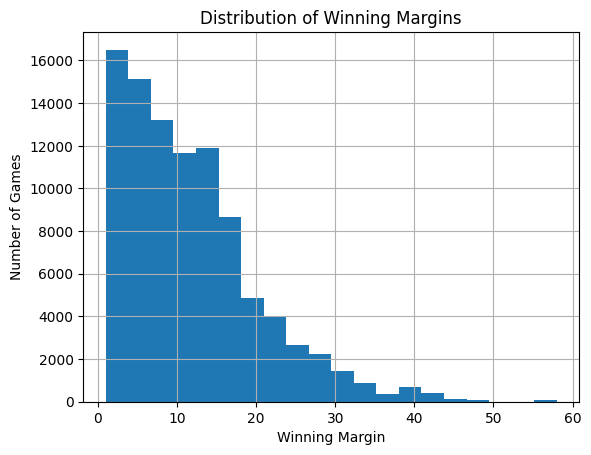

In [159]:
import matplotlib.pyplot as plt
tourney_results["WinMargin"].hist(bins=20)
plt.xlabel("Winning Margin")
plt.ylabel("Number of Games")
plt.title("Distribution of Winning Margins")
plt.show()

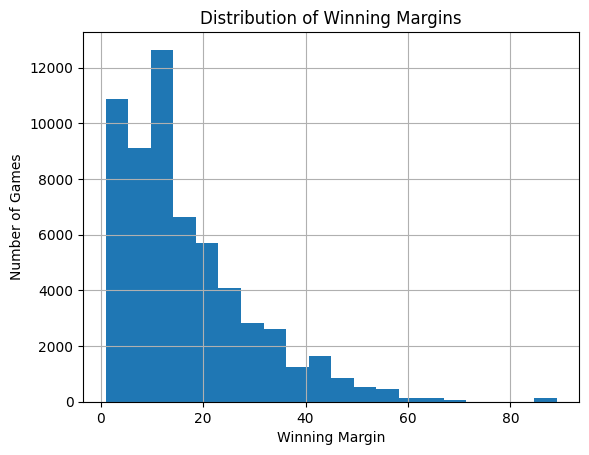

In [160]:
import matplotlib.pyplot as plt
wtourney_results["WinMargin"].hist(bins=20)
plt.xlabel("Winning Margin")
plt.ylabel("Number of Games")
plt.title("Distribution of Winning Margins")
plt.show()

In [161]:
print(tourney_results["WLoc"].value_counts())

WLoc
N    94779
Name: count, dtype: int64


In [162]:
print(wtourney_results["WLoc"].value_counts())

WLoc
N    36690
H    19546
A     3426
Name: count, dtype: int64


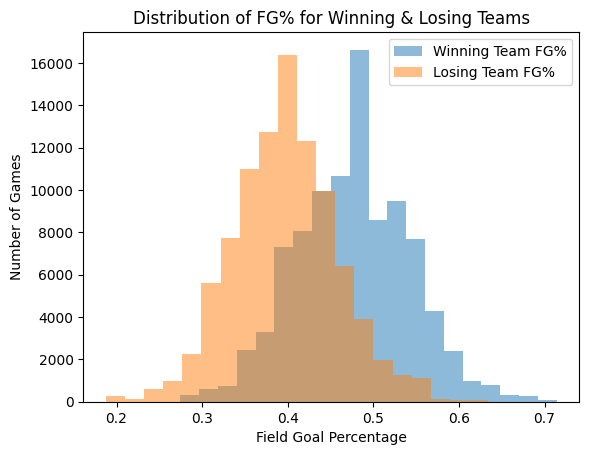

In [163]:
plt.hist(tourney_results["WFG_Pct"], bins=20, alpha=0.5, label="Winning Team FG%")
plt.hist(tourney_results["LFG_Pct"], bins=20, alpha=0.5, label="Losing Team FG%")
plt.xlabel("Field Goal Percentage")
plt.ylabel("Number of Games")
plt.title("Distribution of FG% for Winning & Losing Teams")
plt.legend()
plt.show()

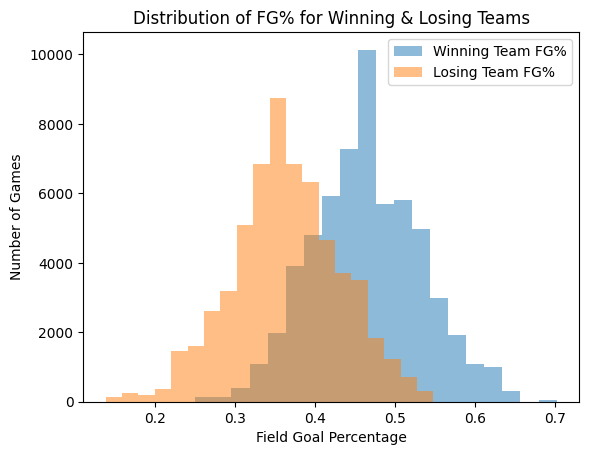

In [164]:
plt.hist(wtourney_results["WFG_Pct"], bins=20, alpha=0.5, label="Winning Team FG%")
plt.hist(wtourney_results["LFG_Pct"], bins=20, alpha=0.5, label="Losing Team FG%")
plt.xlabel("Field Goal Percentage")
plt.ylabel("Number of Games")
plt.title("Distribution of FG% for Winning & Losing Teams")
plt.legend()
plt.show()

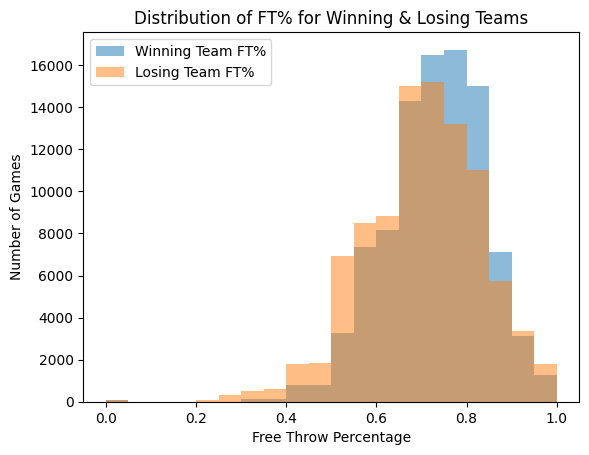

In [165]:
plt.hist(tourney_results["WFT_Pct"], bins=20, alpha=0.5, label="Winning Team FT%")
plt.hist(tourney_results["LFT_Pct"], bins=20, alpha=0.5, label="Losing Team FT%")
plt.xlabel("Free Throw Percentage")
plt.ylabel("Number of Games")
plt.title("Distribution of FT% for Winning & Losing Teams")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


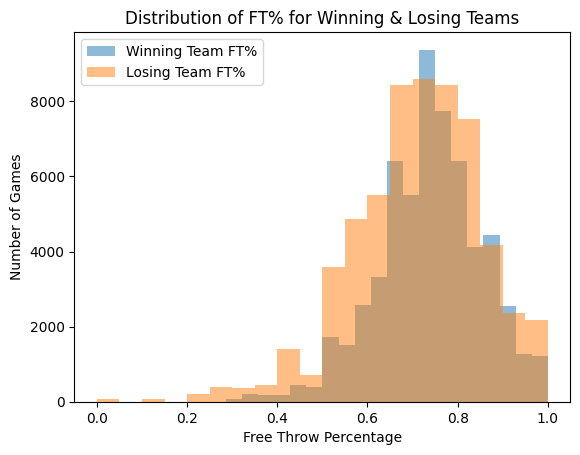

In [166]:
plt.hist(wtourney_results["WFT_Pct"], bins=20, alpha=0.5, label="Winning Team FT%")
plt.hist(wtourney_results["LFT_Pct"], bins=20, alpha=0.5, label="Losing Team FT%")
plt.xlabel("Free Throw Percentage")
plt.ylabel("Number of Games")
plt.title("Distribution of FT% for Winning & Losing Teams")
plt.legend()
plt.show()

In [167]:

# Create a copy for losing teams with inverted features
losses = tourney_results.copy()

# Swap columns to balance the dataset
losses["Win"] = 0  # Losing team
losses["Seed_Diff"] = -losses["Seed_Diff"]
losses["WinMargin"] = -losses["WinMargin"]
# Rename columns for consistency
swap_cols = {
    "WTeamID": "LTeamID", "LTeamID": "WTeamID",
    "WSeedNum": "LSeedNum", "LSeedNum": "WSeedNum",
    "WFG_Pct": "LFG_Pct", "LFG_Pct": "WFG_Pct",
    "W3P_Pct": "L3P_Pct", "L3P_Pct": "W3P_Pct",
    "WFT_Pct": "LFT_Pct", "LFT_Pct": "WFT_Pct"
}
losses = losses.rename(columns=swap_cols)

# Original dataset: winners labeled as 1
tourney_results["Win"] = 1

# Combine the two datasets
final_data = pd.concat([tourney_results, losses], ignore_index=True)

# Define features and target variable
features = ["Seed_Diff", "WFG_Pct", "LFG_Pct", "W3P_Pct", "L3P_Pct", "WFT_Pct", "LFT_Pct"]
X = final_data[features]
y = final_data["Win"]

In [168]:

# Create a copy for losing teams with inverted features
wlosses = wtourney_results.copy()

# Swap columns to balance the dataset
wlosses["Win"] = 0  # Losing team
wlosses["Seed_Diff"] = -wlosses["Seed_Diff"]
wlosses["WinMargin"] = -wlosses["WinMargin"]
# Rename columns for consistency
wswap_cols = {
    "WTeamID": "LTeamID", "LTeamID": "WTeamID",
    "WSeedNum": "LSeedNum", "LSeedNum": "WSeedNum",
    "WFG_Pct": "LFG_Pct", "LFG_Pct": "WFG_Pct",
    "W3P_Pct": "L3P_Pct", "L3P_Pct": "W3P_Pct",
    "WFT_Pct": "LFT_Pct", "LFT_Pct": "WFT_Pct"
}
wlosses = wlosses.rename(columns=wswap_cols)

# Original dataset: winners labeled as 1
wtourney_results["Win"] = 1

# Combine the two datasets
wfinal_data = pd.concat([wtourney_results, wlosses], ignore_index=True)

# Define features and target variable
wfeatures = ["Seed_Diff", "WFG_Pct", "LFG_Pct", "W3P_Pct", "L3P_Pct", "WFT_Pct", "LFT_Pct"]
A = wfinal_data[wfeatures]
b = wfinal_data["Win"]

In [169]:
from sklearn.model_selection import train_test_split

# 80-20 Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [170]:
from sklearn.model_selection import train_test_split

# 80-20 Train-Test split
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=42)

In [171]:
# Convert datasets into XGBoost DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define model parameters
params = {
    "objective": "binary:logistic",
    "learning_rate": 0.05,  # Reduced learning rate
    "max_depth": 4,
    "eval_metric": "logloss"
}

# Train model with early stopping
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,  # Increased number of trees
    evals=[(dtest, "test")],  # Validation set for early stopping
    early_stopping_rounds=30  # Stop if no improvement in 20 rounds
)

[0]	test-logloss:0.66681
[1]	test-logloss:0.64283
[2]	test-logloss:0.62110
[3]	test-logloss:0.60094
[4]	test-logloss:0.58260
[5]	test-logloss:0.56538
[6]	test-logloss:0.54960
[7]	test-logloss:0.53491
[8]	test-logloss:0.52134
[9]	test-logloss:0.50838
[10]	test-logloss:0.49638
[11]	test-logloss:0.48532
[12]	test-logloss:0.47475
[13]	test-logloss:0.46493
[14]	test-logloss:0.45559
[15]	test-logloss:0.44649
[16]	test-logloss:0.43839
[17]	test-logloss:0.43017
[18]	test-logloss:0.42268
[19]	test-logloss:0.41530
[20]	test-logloss:0.40835
[21]	test-logloss:0.40177
[22]	test-logloss:0.39593
[23]	test-logloss:0.38992
[24]	test-logloss:0.38458
[25]	test-logloss:0.37898
[26]	test-logloss:0.37373
[27]	test-logloss:0.36912
[28]	test-logloss:0.36437
[29]	test-logloss:0.35981
[30]	test-logloss:0.35564
[31]	test-logloss:0.35144
[32]	test-logloss:0.34762
[33]	test-logloss:0.34369
[34]	test-logloss:0.33990
[35]	test-logloss:0.33644
[36]	test-logloss:0.33290
[37]	test-logloss:0.32975
[38]	test-logloss:0.32

In [172]:
# Convert datasets into XGBoost DMatrix format
wdtrain = xgb.DMatrix(A_train, label=b_train)
wdtest = xgb.DMatrix(A_test, label=b_test)

# Define model parameters
params = {
    "objective": "binary:logistic",
    "learning_rate": 0.05,  # Reduced learning rate
    "max_depth": 4,
    "eval_metric": "logloss"
}

# Train model with early stopping
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,  # Increased number of trees
    evals=[(wdtest, "test")],  # Validation set for early stopping
    early_stopping_rounds=30  # Stop if no improvement in 20 rounds
)

[0]	test-logloss:0.66677
[1]	test-logloss:0.64203
[2]	test-logloss:0.61891
[3]	test-logloss:0.59821
[4]	test-logloss:0.57918
[5]	test-logloss:0.56100
[6]	test-logloss:0.54483
[7]	test-logloss:0.52984
[8]	test-logloss:0.51603
[9]	test-logloss:0.50277
[10]	test-logloss:0.49094
[11]	test-logloss:0.47906
[12]	test-logloss:0.46836
[13]	test-logloss:0.45816
[14]	test-logloss:0.44938
[15]	test-logloss:0.44101
[16]	test-logloss:0.43315
[17]	test-logloss:0.42592
[18]	test-logloss:0.41886
[19]	test-logloss:0.41174
[20]	test-logloss:0.40443
[21]	test-logloss:0.39760
[22]	test-logloss:0.39274
[23]	test-logloss:0.38658
[24]	test-logloss:0.38135
[25]	test-logloss:0.37576
[26]	test-logloss:0.37057
[27]	test-logloss:0.36622
[28]	test-logloss:0.36146
[29]	test-logloss:0.35699
[30]	test-logloss:0.35373
[31]	test-logloss:0.34994
[32]	test-logloss:0.34688
[33]	test-logloss:0.34328
[34]	test-logloss:0.33981
[35]	test-logloss:0.33787
[36]	test-logloss:0.33422
[37]	test-logloss:0.33262
[38]	test-logloss:0.32

In [173]:
# Make predictions
y_pred_proba = xgb_model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Log Loss: {logloss}")
print(f"AUC Score: {auc}")

Accuracy: 0.9136684954631779
Log Loss: 0.209680584632166
AUC Score: 0.9791833466907109


In [174]:
# Make predictions
b_pred_proba = xgb_model.predict(wdtest)
b_pred = (b_pred_proba > 0.5).astype(int)

# Evaluate performance
accuracy = accuracy_score(b_test, b_pred)
logloss = log_loss(b_test, b_pred_proba)
auc = roc_auc_score(b_test, b_pred_proba)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Log Loss: {logloss}")
print(f"AUC Score: {auc}")

Accuracy: 0.8844751728472658
Log Loss: 0.2773940936182966
AUC Score: 0.9530674319031217


In [175]:
train_preds = xgb_model.predict(dtrain)
train_labels = (train_preds > 0.5).astype(int)

train_acc = accuracy_score(y_train, train_labels)
print(f"Training Accuracy: {train_acc}")

Training Accuracy: 0.9155005737045487


In [176]:
wtrain_preds = xgb_model.predict(wdtrain)
wtrain_labels = (wtrain_preds > 0.5).astype(int)

wtrain_acc = accuracy_score(b_train, wtrain_labels)
print(f"Training Accuracy: {wtrain_acc}")

Training Accuracy: 0.8823473952167946


In [177]:
from sklearn.metrics import brier_score_loss

# Make predictions
y_pred_proba = xgb_model.predict(dtest)  # Probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert to binary predictions

# Compute Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
brier_score = brier_score_loss(y_test, y_pred_proba)  # <-- Added Brier Score Calculation

# Print All Evaluation Results
print(f"Accuracy: {accuracy}")
print(f"Log Loss: {logloss}")
print(f"AUC Score: {auc}")
print(f"Brier Score: {brier_score}")  # <-- Added Brier Score Output

Accuracy: 0.9136684954631779
Log Loss: 0.209680584632166
AUC Score: 0.9791833466907109
Brier Score: 0.061603974070730844


In [178]:
from sklearn.metrics import brier_score_loss

# Make predictions
b_pred_proba = xgb_model.predict(wdtest)  # Probabilities
b_pred = (b_pred_proba > 0.5).astype(int)  # Convert to binary predictions

# Compute Performance Metrics
accuracy = accuracy_score(b_test, b_pred)
logloss = log_loss(b_test, b_pred_proba)
auc = roc_auc_score(b_test, b_pred_proba)
brier_score = brier_score_loss(b_test, b_pred_proba)  # <-- Added Brier Score Calculation

# Woman Print All Evaluation Results
print(f"Accuracy: {accuracy}")
print(f"Log Loss: {logloss}")
print(f"AUC Score: {auc}")
print(f"Womens Champion Brier Score: {brier_score}")  # <-- Added Brier Score Output

Accuracy: 0.8844751728472658
Log Loss: 0.2773940936182966
AUC Score: 0.9530674319031217
Womens Champion Brier Score: 0.08494747023623704


# **Generate Possible Matchups for Predictions**

In [179]:
# Combine both winning and losing teams
teams_2025 = set(tourney_results["WTeamID"]).union(set(tourney_results["LTeamID"]))

In [180]:
# Combine both winning and losing teams
wteams_2025 = set(wtourney_results["WTeamID"]).union(set(wtourney_results["LTeamID"]))

In [181]:
# Convert back to list
teams_2025 = list(teams_2025)

In [182]:
# Convert back to list
wteams_2025 = list(wteams_2025)

In [183]:
# Generate all possible matchups
import itertools
matchup_list = list(itertools.combinations(teams_2025, 2))

In [184]:
# Generate all possible matchups
import itertools
wmatchup_list = list(itertools.combinations(wteams_2025, 2))

In [185]:
matchups_2025 = pd.DataFrame(matchup_list, columns=["Team1", "Team2"])

In [186]:
wmatchups_2025 = pd.DataFrame(wmatchup_list, columns=["Team1", "Team2"])

In [187]:
print(f"Total possible matchups : {len(matchups_2025)}")
print(matchups_2025.head())

Total possible matchups : 47586
    Team1   Team2
0  1101.0  1102.0
1  1101.0  1103.0
2  1101.0  1104.0
3  1101.0  1105.0
4  1101.0  1106.0


In [188]:
print(f"Total possible matchups women's: {len(wmatchups_2025)}")
print(wmatchups_2025.head())

Total possible matchups women's: 38781
    Team1   Team2
0  3101.0  3103.0
1  3101.0  3104.0
2  3101.0  3106.0
3  3101.0  3107.0
4  3101.0  3108.0


In [189]:
# Combine stats from both winning and losing teams
team_stats_win = tourney_results.groupby("WTeamID").agg({
    "WFG_Pct": "mean",
    "W3P_Pct": "mean",
    "WFT_Pct": "mean",
    "WSeedNum": "mean"
}).reset_index()
team_stats_win.rename(columns={"WTeamID": "TeamID"}, inplace=True)

team_stats_loss = tourney_results.groupby("LTeamID").agg({
    "LFG_Pct": "mean",
    "L3P_Pct": "mean",
    "LFT_Pct": "mean",
    "LSeedNum": "mean"
}).reset_index()
team_stats_loss.rename(columns={
    "LTeamID": "TeamID",
    "LFG_Pct": "WFG_Pct",  # Rename to match winning stats format
    "L3P_Pct": "W3P_Pct",
    "LFT_Pct": "WFT_Pct",
    "LSeedNum": "WSeedNum"
}, inplace=True)

In [190]:
# Combine stats from both winning and losing teams
wteam_stats_win = wtourney_results.groupby("WTeamID").agg({
    "WFG_Pct": "mean",
    "W3P_Pct": "mean",
    "WFT_Pct": "mean",
    "WSeedNum": "mean"
}).reset_index()
wteam_stats_win.rename(columns={"WTeamID": "TeamID"}, inplace=True)

wteam_stats_loss = wtourney_results.groupby("LTeamID").agg({
    "LFG_Pct": "mean",
    "L3P_Pct": "mean",
    "LFT_Pct": "mean",
    "LSeedNum": "mean"
}).reset_index()
wteam_stats_loss.rename(columns={
    "LTeamID": "TeamID",
    "LFG_Pct": "WFG_Pct",  # Rename to match winning stats format
    "L3P_Pct": "W3P_Pct",
    "LFT_Pct": "WFT_Pct",
    "LSeedNum": "WSeedNum"
}, inplace=True)

In [191]:
# Combine winning and losing team stats into one dataframe
team_stats = pd.concat([team_stats_win, team_stats_loss]).groupby("TeamID").mean().reset_index()

# Display team stats to confirm it looks correct
print(team_stats.head())

   TeamID   WFG_Pct   W3P_Pct   WFT_Pct   WSeedNum
0  1101.0  0.305931  0.192538  0.745750  14.246324
1  1102.0  0.472840  0.399227  0.772379  11.984615
2  1103.0  0.370796  0.258133  0.658136  13.396450
3  1104.0  0.455201  0.358421  0.700255   5.683037
4  1105.0  0.389920  0.356299  0.721886  16.000000


In [192]:
# Combine winning and losing team stats into one dataframe
wteam_stats = pd.concat([wteam_stats_win, wteam_stats_loss]).groupby("TeamID").mean().reset_index()

# Display team stats to confirm it looks correct
print(wteam_stats.head())

   TeamID   WFG_Pct   W3P_Pct   WFT_Pct   WSeedNum
0  3101.0  0.247732  0.194932  0.404850  16.000000
1  3103.0  0.313290  0.168471  0.749381  13.000000
2  3104.0  0.450534  0.438394  0.783285   7.942409
3  3106.0  0.273947  0.368850  0.708381  15.000000
4  3107.0  0.423086  0.236485  0.648049  13.163717


In [193]:
print("Unique teams in tournament data:", len(set(tourney_results["WTeamID"]).union(set(tourney_results["LTeamID"]))))
print("Teams in final stats:", len(team_stats))

Unique teams in tournament data: 309
Teams in final stats: 309


In [194]:
print("Unique teams in tournament data for Women's:", len(set(wtourney_results["WTeamID"]).union(set(wtourney_results["LTeamID"]))))
print("Teams in final stats:", len(wteam_stats))

Unique teams in tournament data for Women's: 279
Teams in final stats: 279


In [195]:
# Merge stats for Team1
matchups_2025 = matchups_2025.merge(team_stats, left_on="Team1", right_on="TeamID", how="left").drop(columns=["TeamID"])

# Merge stats for Team2
matchups_2025 = matchups_2025.merge(team_stats, left_on="Team2", right_on="TeamID", how="left", suffixes=("_T1", "_T2")).drop(columns=["TeamID"])

In [196]:
# Merge stats for Team1
wmatchups_2025 = wmatchups_2025.merge(wteam_stats, left_on="Team1", right_on="TeamID", how="left").drop(columns=["TeamID"])

# Merge stats for Team2
wmatchups_2025 = wmatchups_2025.merge(wteam_stats, left_on="Team2", right_on="TeamID", how="left", suffixes=("_T1", "_T2")).drop(columns=["TeamID"])

In [197]:
# Check merged data
print(matchups_2025.head())

    Team1   Team2  WFG_Pct_T1  W3P_Pct_T1  WFT_Pct_T1  WSeedNum_T1  \
0  1101.0  1102.0    0.305931    0.192538     0.74575    14.246324   
1  1101.0  1103.0    0.305931    0.192538     0.74575    14.246324   
2  1101.0  1104.0    0.305931    0.192538     0.74575    14.246324   
3  1101.0  1105.0    0.305931    0.192538     0.74575    14.246324   
4  1101.0  1106.0    0.305931    0.192538     0.74575    14.246324   

   WFG_Pct_T2  W3P_Pct_T2  WFT_Pct_T2  WSeedNum_T2  
0    0.472840    0.399227    0.772379    11.984615  
1    0.370796    0.258133    0.658136    13.396450  
2    0.455201    0.358421    0.700255     5.683037  
3    0.389920    0.356299    0.721886    16.000000  
4    0.351359    0.252166    0.630014    16.000000  


In [198]:
# Check merged data
print(wmatchups_2025.head())

    Team1   Team2  WFG_Pct_T1  W3P_Pct_T1  WFT_Pct_T1  WSeedNum_T1  \
0  3101.0  3103.0    0.247732    0.194932     0.40485         16.0   
1  3101.0  3104.0    0.247732    0.194932     0.40485         16.0   
2  3101.0  3106.0    0.247732    0.194932     0.40485         16.0   
3  3101.0  3107.0    0.247732    0.194932     0.40485         16.0   
4  3101.0  3108.0    0.247732    0.194932     0.40485         16.0   

   WFG_Pct_T2  W3P_Pct_T2  WFT_Pct_T2  WSeedNum_T2  
0    0.313290    0.168471    0.749381    13.000000  
1    0.450534    0.438394    0.783285     7.942409  
2    0.273947    0.368850    0.708381    15.000000  
3    0.423086    0.236485    0.648049    13.163717  
4    0.363058    0.282112    0.710379    16.000000  


In [199]:
# Compute feature differences (Team1 - Team2)
matchups_2025["Seed_Diff"] = matchups_2025["WSeedNum_T1"] - matchups_2025["WSeedNum_T2"]
matchups_2025["WFG_Pct"] = matchups_2025["WFG_Pct_T1"] - matchups_2025["WFG_Pct_T2"]
matchups_2025["LFG_Pct"] = matchups_2025["WFG_Pct_T2"] - matchups_2025["WFG_Pct_T1"]
matchups_2025["W3P_Pct"] = matchups_2025["W3P_Pct_T1"] - matchups_2025["W3P_Pct_T2"]
matchups_2025["L3P_Pct"] = matchups_2025["W3P_Pct_T2"] - matchups_2025["W3P_Pct_T1"]
matchups_2025["WFT_Pct"] = matchups_2025["WFT_Pct_T1"] - matchups_2025["WFT_Pct_T2"]
matchups_2025["LFT_Pct"] = matchups_2025["WFT_Pct_T2"] - matchups_2025["WFT_Pct_T1"]

# Keep only relevant columns for prediction
X_matchups = matchups_2025[["Seed_Diff", "WFG_Pct", "LFG_Pct", "W3P_Pct", "L3P_Pct", "WFT_Pct", "LFT_Pct"]]

In [200]:
# Compute feature differences (Team1 - Team2)
wmatchups_2025["Seed_Diff"] = wmatchups_2025["WSeedNum_T1"] - wmatchups_2025["WSeedNum_T2"]
wmatchups_2025["WFG_Pct"] = wmatchups_2025["WFG_Pct_T1"] - wmatchups_2025["WFG_Pct_T2"]
wmatchups_2025["LFG_Pct"] = wmatchups_2025["WFG_Pct_T2"] - wmatchups_2025["WFG_Pct_T1"]
wmatchups_2025["W3P_Pct"] = wmatchups_2025["W3P_Pct_T1"] - wmatchups_2025["W3P_Pct_T2"]
wmatchups_2025["L3P_Pct"] = wmatchups_2025["W3P_Pct_T2"] - wmatchups_2025["W3P_Pct_T1"]
wmatchups_2025["WFT_Pct"] = wmatchups_2025["WFT_Pct_T1"] - wmatchups_2025["WFT_Pct_T2"]
wmatchups_2025["LFT_Pct"] = wmatchups_2025["WFT_Pct_T2"] - wmatchups_2025["WFT_Pct_T1"]

# Keep only relevant columns for prediction
WX_matchups = wmatchups_2025[["Seed_Diff", "WFG_Pct", "LFG_Pct", "W3P_Pct", "L3P_Pct", "WFT_Pct", "LFT_Pct"]]

In [201]:
# Check feature differences
print(X_matchups.head())

   Seed_Diff   WFG_Pct   LFG_Pct   W3P_Pct   L3P_Pct   WFT_Pct   LFT_Pct
0   2.261708 -0.166909  0.166909 -0.206689  0.206689 -0.026629  0.026629
1   0.849874 -0.064865  0.064865 -0.065595  0.065595  0.087614 -0.087614
2   8.563286 -0.149270  0.149270 -0.165883  0.165883  0.045495 -0.045495
3  -1.753676 -0.083989  0.083989 -0.163761  0.163761  0.023865 -0.023865
4  -1.753676 -0.045429  0.045429 -0.059628  0.059628  0.115737 -0.115737


In [202]:
# Check feature differences
print(WX_matchups.head())

   Seed_Diff   WFG_Pct   LFG_Pct   W3P_Pct   L3P_Pct   WFT_Pct   LFT_Pct
0   3.000000 -0.065558  0.065558  0.026462 -0.026462 -0.344531  0.344531
1   8.057591 -0.202802  0.202802 -0.243462  0.243462 -0.378436  0.378436
2   1.000000 -0.026215  0.026215 -0.173918  0.173918 -0.303531  0.303531
3   2.836283 -0.175354  0.175354 -0.041553  0.041553 -0.243200  0.243200
4   0.000000 -0.115326  0.115326 -0.087180  0.087180 -0.305530  0.305530


In [203]:
import xgboost as xgb

# Convert to DMatrix (XGBoost format)
dmatch_2025 = xgb.DMatrix(X_matchups)

In [204]:
import xgboost as xgb

# Convert to DMatrix (XGBoost format)
wdmatch_2025 = xgb.DMatrix(WX_matchups)

In [205]:
# Predict win probabilities
matchups_2025["Win_Prob_Team1"] = xgb_model.predict(dmatch_2025)

In [206]:
# Predict win probabilities
wmatchups_2025["Win_Prob_Team1"] = xgb_model.predict(wdmatch_2025)

In [207]:
# Predict the winner
matchups_2025["Predicted_Winner"] = matchups_2025.apply(
    lambda row: row["Team1"] if row["Win_Prob_Team1"] > 0.5 else row["Team2"], axis=1
)

# Display predictions
print("Predicted matchups for 2025:\n", matchups_2025[["Team1", "Team2", "Win_Prob_Team1", "Predicted_Winner"]].head())

Predicted matchups for 2025:
     Team1   Team2  Win_Prob_Team1  Predicted_Winner
0  1101.0  1102.0        0.099755            1102.0
1  1101.0  1103.0        0.470287            1103.0
2  1101.0  1104.0        0.067219            1104.0
3  1101.0  1105.0        0.651910            1101.0
4  1101.0  1106.0        0.794410            1101.0


In [208]:
# Predict the winner
wmatchups_2025["Predicted_Winner"] = wmatchups_2025.apply(
    lambda row: row["Team1"] if row["Win_Prob_Team1"] > 0.5 else row["Team2"], axis=1
)

# Display predictions
print("Predicted matchups for 2025:\n", wmatchups_2025[["Team1", "Team2", "Win_Prob_Team1", "Predicted_Winner"]].head())

Predicted matchups for 2025:
     Team1   Team2  Win_Prob_Team1  Predicted_Winner
0  3101.0  3103.0        0.239105            3103.0
1  3101.0  3104.0        0.053932            3104.0
2  3101.0  3106.0        0.185074            3106.0
3  3101.0  3107.0        0.239105            3107.0
4  3101.0  3108.0        0.470287            3108.0


In [209]:
# Ensure Team1 is always the predicted winner
matchups_2025["Losing_Team"] = matchups_2025.apply(
    lambda row: row["Team2"] if row["Predicted_Winner"] == row["Team1"] else row["Team1"], axis=1
)

matchups_2025["Team1"] = matchups_2025["Predicted_Winner"]
matchups_2025["Team2"] = matchups_2025["Losing_Team"]

# Drop the temporary column
matchups_2025.drop(columns=["Losing_Team"], inplace=True)

# Display sorted matchups
print("Sorted matchups for 2025:\n", matchups_2025[["Team1", "Team2", "Win_Prob_Team1", "Predicted_Winner"]].head())

Sorted matchups for 2025:
     Team1   Team2  Win_Prob_Team1  Predicted_Winner
0  1102.0  1101.0        0.099755            1102.0
1  1103.0  1101.0        0.470287            1103.0
2  1104.0  1101.0        0.067219            1104.0
3  1101.0  1105.0        0.651910            1101.0
4  1101.0  1106.0        0.794410            1101.0


In [210]:
# Ensure Team1 is always the predicted winner
wmatchups_2025["Losing_Team"] = wmatchups_2025.apply(
    lambda row: row["Team2"] if row["Predicted_Winner"] == row["Team1"] else row["Team1"], axis=1
)

wmatchups_2025["Team1"] = wmatchups_2025["Predicted_Winner"]
wmatchups_2025["Team2"] = wmatchups_2025["Losing_Team"]

# Drop the temporary column
wmatchups_2025.drop(columns=["Losing_Team"], inplace=True)

# Display sorted matchups
print("Sorted matchups for 2025:\n", wmatchups_2025[["Team1", "Team2", "Win_Prob_Team1", "Predicted_Winner"]].head())

Sorted matchups for 2025:
     Team1   Team2  Win_Prob_Team1  Predicted_Winner
0  3103.0  3101.0        0.239105            3103.0
1  3104.0  3101.0        0.053932            3104.0
2  3106.0  3101.0        0.185074            3106.0
3  3107.0  3101.0        0.239105            3107.0
4  3108.0  3101.0        0.470287            3108.0


In [211]:
import pandas as pd

# Create a new column in the format '2025_Team1_Team2'
matchups_2025["ID"] = matchups_2025.apply(
    lambda row: f"2025_{int(row['Team1'])}_{int(row['Team2'])}", axis=1
)

# Create final_prediction DataFrame with the desired columns
final_prediction = matchups_2025[["ID", "Win_Prob_Team1"]].copy()
final_prediction.rename(columns={"Win_Prob_Team1": "Pred"}, inplace=True)

# Display final predictions
print(final_prediction.head())

               ID      Pred
0  2025_1102_1101  0.099755
1  2025_1103_1101  0.470287
2  2025_1104_1101  0.067219
3  2025_1101_1105  0.651910
4  2025_1101_1106  0.794410


In [212]:
import pandas as pd

# Create a new column in the format '2025_Team1_Team2'
wmatchups_2025["ID"] = wmatchups_2025.apply(
    lambda row: f"2025_{int(row['Team1'])}_{int(row['Team2'])}", axis=1
)

# Create final_prediction DataFrame with the desired columns
wfinal_prediction = wmatchups_2025[["ID", "Win_Prob_Team1"]].copy()
wfinal_prediction.rename(columns={"Win_Prob_Team1": "Pred"}, inplace=True)

# Display final predictions
print(wfinal_prediction.head())

               ID      Pred
0  2025_3103_3101  0.239105
1  2025_3104_3101  0.053932
2  2025_3106_3101  0.185074
3  2025_3107_3101  0.239105
4  2025_3108_3101  0.470287


In [213]:
print(len(final_prediction))

47586


In [214]:
print(len(wfinal_prediction))

38781


In [215]:
final_prediction.to_csv("SampleSubmissionStage2.csv", index=False)

In [216]:
wfinal_prediction.to_csv("WSampleSubmissionStage2.csv", index=False)

In [217]:
# Step 1: Start with all teams that won at least once
qualified_teams = set(matchups_2025["Predicted_Winner"])
team_wins = matchups_2025["Predicted_Winner"].value_counts().to_dict()  # Track wins per team

# Simulate rounds until only 2 teams remain
while len(qualified_teams) > 2:
    new_round_winners = set()

    for team in qualified_teams:
        # Get matchups involving this team
        potential_matchups = matchups_2025[
            (matchups_2025["Team1"].isin(qualified_teams)) &
            (matchups_2025["Team2"].isin(qualified_teams))
        ]

        # Ensure valid matchups exist
        if not potential_matchups.empty:
            # Count wins for each remaining team
            winners = potential_matchups.groupby("Predicted_Winner").size().reset_index(name="Wins")

            # Select the top teams based on the highest win counts
            top_winners = winners.sort_values(by="Wins", ascending=False)["Predicted_Winner"].tolist()

            # Select top winners for the next round
            new_round_winners.update(top_winners[:len(qualified_teams) // 2])  # Keep strongest half

    # Prevent infinite loop: If no progress, pick top teams manually
    if len(new_round_winners) >= len(qualified_teams):
        print("Tournament stuck, selecting top teams based on total wins.")
        qualified_teams = set(sorted(team_wins, key=team_wins.get, reverse=True)[:2])
        break

    qualified_teams = new_round_winners

In [218]:
# Step 1: Start with all teams that won at least once
wqualified_teams = set(wmatchups_2025["Predicted_Winner"])
wteam_wins = wmatchups_2025["Predicted_Winner"].value_counts().to_dict()  # Track wins per team

# Simulate rounds until only 2 teams remain
while len(wqualified_teams) > 2:
    wnew_round_winners = set()

    for team in wqualified_teams:
        # Get matchups involving this team
        wpotential_matchups = wmatchups_2025[
            (wmatchups_2025["Team1"].isin(wqualified_teams)) &
            (wmatchups_2025["Team2"].isin(wqualified_teams))
        ]

        # Ensure valid matchups exist
        if not wpotential_matchups.empty:
            # Count wins for each remaining team
            wwinners = wpotential_matchups.groupby("Predicted_Winner").size().reset_index(name="Wins")

            # Select the top teams based on the highest win counts
            wtop_winners = wwinners.sort_values(by="Wins", ascending=False)["Predicted_Winner"].tolist()

            # Select top winners for the next round
            wnew_round_winners.update(wtop_winners[:len(wqualified_teams) // 2])  # Keep strongest half

    # Prevent infinite loop: If no progress, pick top teams manually
    if len(wnew_round_winners) >= len(wqualified_teams):
        print("Tournament stuck, selecting top teams based on total wins.")
        wqualified_teams = set(sorted(wteam_wins, key=wteam_wins.get, reverse=True)[:2])
        break

    wqualified_teams = wnew_round_winners

In [219]:
# Step 2: Identify the final two teams
final_teams = list(qualified_teams)
print(f"The final teams are: {final_teams[0]} vs. {final_teams[1]}")

The final teams are: 1242.0 vs. 1181.0


In [220]:
# Step 2: Identify the final two teams
wfinal_teams = list(wqualified_teams)
print(f"The final teams are: {wfinal_teams[0]} vs. {wfinal_teams[1]}")

The final teams are: 3163.0 vs. 3323.0


In [221]:
# Debugging: Check if a final matchup exists
print(f"Checking final matchup for: {final_teams[0]} vs {final_teams[1]}")

# Ensure `final_matchup` is assigned before printing
final_matchup = matchups_2025[
    ((matchups_2025["Team1"] == final_teams[0]) & (matchups_2025["Team2"] == final_teams[1])) |
    ((matchups_2025["Team1"] == final_teams[1]) & (matchups_2025["Team2"] == final_teams[0]))
]

print(final_matchup)  # Now it's correctly defined

# If the matchup exists, use the predicted winner
if not final_matchup.empty:
    final_winner = final_matchup.iloc[0]["Predicted_Winner"]
    print(f"The 2025 NCAA Tournament Champion is: {final_winner}!")
else:
    print("⚠ No final matchup found. Predicting manually...")

    # Get team stats
    team1_stats = team_stats[team_stats["TeamID"] == final_teams[0]]
    team2_stats = team_stats[team_stats["TeamID"] == final_teams[1]]

    if team1_stats.empty or team2_stats.empty:
        print("⚠ Missing team stats. Cannot predict the final game.")
    else:
        # Compute feature differences
        final_matchup_data = pd.DataFrame({
            "Seed_Diff": team1_stats["WSeedNum"].values[0] - team2_stats["WSeedNum"].values[0],
            "WFG_Pct": team1_stats["WFG_Pct"].values[0] - team2_stats["WFG_Pct"].values[0],
            "LFG_Pct": team2_stats["WFG_Pct"].values[0] - team1_stats["WFG_Pct"].values[0],
            "W3P_Pct": team1_stats["W3P_Pct"].values[0] - team2_stats["W3P_Pct"].values[0],
            "L3P_Pct": team2_stats["W3P_Pct"].values[0] - team1_stats["W3P_Pct"].values[0],
            "WFT_Pct": team1_stats["WFT_Pct"].values[0] - team2_stats["WFT_Pct"].values[0],
            "LFT_Pct": team2_stats["WFT_Pct"].values[0] - team1_stats["WFT_Pct"].values[0]
        }, index=[0])

        print("Final matchup data for prediction:", final_matchup_data)

        # Convert to DMatrix
        final_matchup_dmatrix = xgb.DMatrix(final_matchup_data)

        # Predict the final winner
        win_prob = xgb_model.predict(final_matchup_dmatrix)[0]
        final_winner = final_teams[0] if win_prob > 0.5 else final_teams[1]
        print(f"The manually predicted 2025 NCAA Champion is: {final_winner}!")

Checking final matchup for: 1242.0 vs 1181.0
        Team1   Team2  WFG_Pct_T1  W3P_Pct_T1  WFT_Pct_T1  WSeedNum_T1  \
17749  1242.0  1181.0    0.438876    0.333151    0.736273     2.102171   

       WFG_Pct_T2  W3P_Pct_T2  WFT_Pct_T2  WSeedNum_T2  Seed_Diff   WFG_Pct  \
17749    0.456993    0.330273    0.701931     1.866395   0.235776 -0.018118   

        LFG_Pct   W3P_Pct   L3P_Pct   WFT_Pct   LFT_Pct  Win_Prob_Team1  \
17749  0.018118  0.002878 -0.002878  0.034342 -0.034342        0.470287   

       Predicted_Winner              ID  
17749            1242.0  2025_1242_1181  
The 2025 NCAA Tournament Champion is: 1242.0!


In [222]:
# Debugging: Check if a final matchup exists
print(f"Checking final matchup for: {wfinal_teams[0]} vs {wfinal_teams[1]}")

# Ensure `final_matchup` is assigned before printing
wfinal_matchup = wmatchups_2025[
    ((wmatchups_2025["Team1"] == wfinal_teams[0]) & (wmatchups_2025["Team2"] == wfinal_teams[1])) |
    ((wmatchups_2025["Team1"] == wfinal_teams[1]) & (wmatchups_2025["Team2"] == wfinal_teams[0]))
]

print(wfinal_matchup)  # Now it's correctly defined

# If the matchup exists, use the predicted winner
if not wfinal_matchup.empty:
    wfinal_winner = wfinal_matchup.iloc[0]["Predicted_Winner"]
    print(f"The 2025 NCAA Tournament Champion is: {wfinal_winner}!")
else:
    print("⚠ No final matchup found. Predicting manually...")

    # Get team stats
    wteam1_stats = wteam_stats[wteam_stats["TeamID"] == wfinal_teams[0]]
    wteam2_stats = wteam_stats[wteam_stats["TeamID"] == wfinal_teams[1]]

    if wteam1_stats.empty or wteam2_stats.empty:
        print("⚠ Missing team stats. Cannot predict the final game.")
    else:
        # Compute feature differences
        wfinal_matchup_data = pd.DataFrame({
            "Seed_Diff": wteam1_stats["WSeedNum"].values[0] - wteam2_stats["WSeedNum"].values[0],
            "WFG_Pct": wteam1_stats["WFG_Pct"].values[0] - wteam2_stats["WFG_Pct"].values[0],
            "LFG_Pct": wteam2_stats["WFG_Pct"].values[0] - wteam1_stats["WFG_Pct"].values[0],
            "W3P_Pct": wteam1_stats["W3P_Pct"].values[0] - wteam2_stats["W3P_Pct"].values[0],
            "L3P_Pct": wteam2_stats["W3P_Pct"].values[0] - wteam1_stats["W3P_Pct"].values[0],
            "WFT_Pct": wteam1_stats["WFT_Pct"].values[0] - wteam2_stats["WFT_Pct"].values[0],
            "LFT_Pct": wteam2_stats["WFT_Pct"].values[0] - wteam1_stats["WFT_Pct"].values[0]
        }, index=[0])

        print("Final matchup data for prediction:", wfinal_matchup_data)

        # Convert to DMatrix
        wfinal_matchup_dmatrix = xgb.DMatrix(wfinal_matchup_data)

        # Predict the final winner
        wwin_prob = xgb_model.predict(wfinal_matchup_dmatrix)[0]
        wfinal_winner = wfinal_teams[0] if wwin_prob > 0.5 else wfinal_teams[1]
        print(f"The manually predicted 2025 NCAA Champion is: {wfinal_winner}!")

Checking final matchup for: 3163.0 vs 3323.0
        Team1   Team2  WFG_Pct_T1  W3P_Pct_T1  WFT_Pct_T1  WSeedNum_T1  \
10932  3163.0  3323.0    0.470064    0.359155     0.67834      1.42586   

       WFG_Pct_T2  W3P_Pct_T2  WFT_Pct_T2  WSeedNum_T2  Seed_Diff   WFG_Pct  \
10932    0.446443    0.357047    0.788379     1.569638  -0.143778  0.023622   

        LFG_Pct   W3P_Pct   L3P_Pct   WFT_Pct   LFT_Pct  Win_Prob_Team1  \
10932 -0.023622  0.002108 -0.002108 -0.110039  0.110039        0.540729   

       Predicted_Winner              ID  
10932            3163.0  2025_3163_3323  
The 2025 NCAA Tournament Champion is: 3163.0!


In [223]:
# Create a dictionary to map TeamID to TeamName
team_name_mapping = dict(zip(tourney_results["WTeamID"], tourney_results["WTeamName"]))  # Adjust column names if needed

In [224]:
# Check the name of the champion
final_winner_name = team_name_mapping.get(final_winner, f"Unknown Team ({final_winner})")

In [225]:
print(f"The 2025 NCAA Tournament Champion is: {final_winner_name}!")

The 2025 NCAA Tournament Champion is: Kansas!


In [226]:
# Create a dictionary to map TeamID to TeamName
wteam_name_mapping = dict(zip(wtourney_results["WTeamID"], wtourney_results["WTeamName"]))  # Adjust column names if needed

In [227]:
# Check the name of the champion
wfinal_winner_name = wteam_name_mapping.get(wfinal_winner, f"Unknown Team ({wfinal_winner})")

In [228]:
print(f"The 2025 Women's NCAA Tournament Champion is: {wfinal_winner_name}!")

The 2025 Women's NCAA Tournament Champion is: Connecticut!
